<h3>Imports and File Uploads</h3>

In [1]:
import collections
import datetime
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import mplleaflet
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.csv as csv
import re
import seaborn as sns
from shapely.geometry import Point, Polygon
pd.set_option("display.max_columns", None)
import time



__Dataset 1__: Dataset of census tracts with data on racial makeup, income, distance to work, renting or ownership, household size

In [2]:
df_tracts=pd.read_csv('King_County_ACS_2019_tract.csv') # dataset on census tracts and characteristics 
df_tracts_head= pd.read_excel('ACS_Variables_Selected.xlsx')# column names 
shapefile = gpd.read_file("tl_2021_53_tract /tl_2021_53_tract.shp")# shapefile mapping census tract to GEOID
geojson=gpd.read_file('georef.geojson')# mapping JSON file


__Dataset 2__: Dataset on Subsidized Annual Pass Users for King County Metro

In [3]:
df_SAP=pd.read_csv('Question 2_ Fare Subsidies/LIFT_registry.csv')

__Dataset 3__: Stop Level Granular Dataset on Fare Reinstatement for King County Metro

In [4]:
df_stop_activity=pd.read_csv('/Users/gaurav/Developer/CS474/FinalData/raw_data/Question 1_ Fare Reinstatement/stop_activity_granular_2020-09-01_2020-10-31.csv', engine='pyarrow')
df_matched_stops=pd.read_csv('/Users/gaurav/Developer/CS474/FinalData/raw_data/bus_stop_geoid_matching.csv') # file of stop id matched to geoid for mapping

In [5]:
df_stop_activity

,OPERATION_DATE,BOOKING_ID,SCHED_DAY_TYPE_CODED_NUM,SERVICE_RTE_LIST,TRIP_COMPASS_DIR_CD,KEY_BLOCK_NUM,STOP_SEQUENCE_NUM,STOP_ID,STOP_NM,SCHED_ARRIVAL_SECS_AFTER_MIDNT,FULL_DATE,ACTUAL_ARRIVAL_SECS_AFTER_MIDNT,ACTUAL_DEPARTURE_SECS_AFTER_MIDNT,PSNGR_BOARDINGS,PSNGR_ALIGHTINGS,TRIP_ID,DEP_PSNGR_LOAD
0,2020-09-01,SUM20,0,65,North,6503,13.0,10020,NE 55TH ST & 37TH AVE NE,NaN,09/01/2020,110709,110709,0,0,46931260,2
1,2020-09-01,SUM20,0,120,North,12011,32.0,21560,DELRIDGE WAY SW & SW HUDSON ST,NaN,09/01/2020,123209,123209,0,0,47583182,0
2,2020-09-01,SUM20,0,107,NULL,10714,0.0,41890,S LANDER ST & 15TH AVE S,155200.0,09/01/2020,155345,155345,0,0,47801614,0
3,2020-09-01,SUM20,0,120,NULL,12024,1.0,98141,2ND AVE & LENORA ST,124400.0,09/01/2020,124003,124003,0,0,47583379,0
4,2020-09-01,SUM20,0,671,South,67111,5.0,61100,INTERNATIONAL BLVD & S 188TH ST,NaN,09/01/2020,133751,133818,4,0,47799588,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22506622,2020-10-31,FAL20,1,554,NULL,55401,1.0,99811,HIGHLANDS DR NE,140300.0,10/31/2020,135344,135344,0,0,41801748,0
22506623,2020-10-31,FAL20,1,208,NULL,20801,0.0,99821,ISSAQUAH TRANSIT CENTER,110100.0,10/31/2020,110545,110545,0,0,50721691,0
22506624,2020-10-31,FAL20,1,673,NULL,67302,0.0,92002,ATLANTIC BASE,41400.0,10/31/2020,41304,41304,0,0,49776156,0
22506625,2020-10-31,FAL20,1,676,NULL,67602,0.0,92006,SOUTH BASE,54700.0,10/31/2020,54454,54454,0,0,47804355,0


<h3>Preprocessing</h3>

In [6]:
# dataset 1 preprocessing
df_tracts_head.index=df_tracts_head.Variable_Code+'E'
df_tracts_head=df_tracts_head.drop('Variable_Code',axis=1)
myDict=df_tracts_head['Description'].to_dict()
for key in myDict:
    myDict[key]=re.sub('\W+','', myDict[key])
df_tracts=df_tracts.rename(columns=myDict)
df_tracts = df_tracts.loc[:, ~df_tracts.columns.str.startswith('B')]
df_tracts.index=df_tracts.GEOID
df_tracts=df_tracts.drop(['Unnamed: 0','GEOID'],axis=1)
df_tracts.head()






,NAME,MedianageTotal,EstimateTotal,EstimateTotalRace,EstimateTotalWhite,EstimateTotalAfricanAmerican,EstimateTotalNativeAmericanorAlaskanNative,EstimateTotalAsian,EstimateTotalNativeHawaiianandPacificIslander,EstimateTotalOtherRace,EstimateTotalTwoormoreraces,EstimateTotalNativityandcitizenshipstatus,EstimateTotalUScitizensborninUS,EstimateTotalUScitizensinPRorUSislands,EstimateTotalUScitizensbornabroadofAmericanparents,EstimateTotalUScitizenbynaturalization,EstimateTotalNotaUScitizen,EstimateTotalNativetotal,EstimateTotalForeignBorn,EstimateTotalSpeakonlyEnglish,EstimateTotalSpeakSpanish,EstimateSpanishSpeakEnglishverywell,EstimateSpanishSpeakEnglishlessthanverywell,EstimateTotalSpeakotherlanguages,EstimateOtherlanguagesEnglishlessthanveryweel,EstimateTotalNevermarried,EstimateTotalNowmarriedexceptseparated,EstimateTotalDivorced,EstimateTotalSeparated,EstimateTotalWidowed,EstimateTotalLessthanHS,EstimateTotalHighschoolgraduate,EstimateTotalSomecollege,EstimateTotalBachelorsdegree,EstimateTotalGraduateorprofessionaldegree,Total,Lessthan10000,10000to14999,15000to19999,20000to24999,25000to29999,30000to34999,35000to39999,40000to44999,45000to49999,50000to59999,60000to74999,75000to99999,100000to124999,125000to149999,150000to199999,200000ormore,EstimateTotalMedianincomepast12mnths,EstimateTotalBelow100percentofthepovertylevel,EstimateTotal100to149percentofpovertylevel,EstimateTotalAtorabove150percentofpovertylevel,EstimateTotalsamehouse1yearago,EstimateTotalmovedwithinsamecounty,EstimateTotalManagementbusinessscienceandartsoccupations,EstimateTotalServiceoccupations,EstimateTotalSalesandofficeoccupations,EstimateTotalNaturalresourcesconstructionandmaintenanceoccupations,EstimateTotalMilitary,Agricultureforestryfishingandhuntingandmining,Construction,Manufacturing,Wholesaletrade,Retailtrade,Transportationandwarehousingandutilities,Information,Financeandinsuranceandrealestateandrentalandleasing,Professionalscientificandmanagementandadministrativeandwastemanagementservices,Educationalservicesandhealthcareandsocialassistance,Artsentertainmentandrecreationandaccommodationandfoodservices,Otherservicesexceptpublicadministration,Publicadministration,Armedforces,Householderlivedinowneroccupiedhousingunits,Householderlivedinrenteroccupiedhousingunits,Total,Lessthan5minutes,5to9minutes,10to14minutes,15to19minutes,20to24minutes,25to29minutes,30to34minutes,35to39minutes,40to44minutes,45to59minutes,60to89minutes,90ormoreminutes,Total,Familyhouseholds,Familyhouseholds2personhousehold,Familyhouseholds3personhousehold,Familyhouseholds4personhousehold,Familyhouseholds5personhousehold,Familyhouseholds6personhousehold,Familyhouseholds7ormorepersonhousehold,Nonfamilyhouseholds,Nonfamilyhouseholds1personhousehold,Nonfamilyhouseholds2personhousehold,Nonfamilyhouseholds3personhousehold,Nonfamilyhouseholds4personhousehold,Nonfamilyhouseholds5personhousehold,Nonfamilyhouseholds6personhousehold,Nonfamilyhouseholds7ormorepersonhousehold,Total,Enrolledinschool,EnrolledinschoolEnrolledinnurseryschoolpreschool,EnrolledinschoolEnrolledinkindergarten,EnrolledinschoolEnrolledingrade1tograde4,EnrolledinschoolEnrolledingrade5tograde8,EnrolledinschoolEnrolledingrade9tograde12,EnrolledinschoolEnrolledincollegeundergraduateyears,EnrolledinschoolGraduateorprofessionalschool,Notenrolledinschool,Aggregateearningsinthepast12monthsin2010inflationadjusteddollars,Aggregatewageorsalaryincomeinthepast12monthsin2010inflationadjusteddollars,Aggregateselfemploymentincomeinthepast12monthsin2010inflationadjusteddollars,Aggregateinterestdividendsornetrentalincomeinthepast12monthsin2010inflationadjusteddollars,AggregateSocialSecurityincomeinthepast12monthsin2010inflationadjusteddollars,AggregateSupplementalSecurityIncomeSSIinthepast12monthsin2010inflationadjusteddollars,Aggregatepublicassistanceincomeinthepast12monthsin2010inflationadjusteddollars,Aggregateretirementincomeinthepast12monthsin2010inflationadjusteddollars,Aggregateothertypesofincomeinthepast12monthsin2010inflationadjustedd

In [7]:
# dataset 2 preprocessing
df_SAP=df_SAP[df_SAP['duplicate']==False].drop('duplicate',axis=1) # remove duplicates

df_SAP['FIPS']=df_SAP['FIPS'].dropna() 
df_SAP['GEOID']=df_SAP.FIPS/10
df_SAP=df_SAP.dropna(subset=['GEOID'])
df_SAP.GEOID=df_SAP.GEOID.astype(int)

df_SAP

# converting FIPS from block level to census tract level ( match census data)


,Age,RaceDesc,LanguageSpoken,Expiration,DateIssued,CardIssuingAgency,FIPS,Initial Load,Study Card,card_id,GEOID
0,36,Black or African American,Other,8/31/2019,2017-06-15,KCMCCS,5.303303e+11,NaN,NaN,568-1,53033028802
1,56,White,English,7/31/2019,2017-06-05,YWCA,5.303300e+11,NaN,NaN,2690-1,53033004000
2,58,White,English,11/30/2021,2019-08-28,King County Public Health,5.303300e+11,NaN,NaN,2690-2,53033004000
3,49,Black or African American,English,11/30/2023,2022-01-26,DSHS - ORCA LIFT (remote enrollment),5.305306e+11,10,NaN,2704-1,53053060905
4,46,Asian,English,5/31/2021,2019-06-30,King County Public Health,5.303301e+11,NaN,NaN,2706-1,53033006100
...,...,...,...,...,...,...,...,...,...,...,...
117723,26,White,English,3/31/2025,2022-03-17,King County Public Health,5.303303e+11,10,NaN,272812-1,53033030310
117724,26,Black or African American,English,3/31/2025,2022-03-17,King County Public Health,5.303300e+11,10,NaN,272814-1,53033000401
117725,52,White,English,10/31/2024,2022-03-17,King County Public Health,5.303303e+11,NaN,NaN,272816-1,53033029601
117726,58,Black or African American,English,3/31/2025,2022-03-17,King County Public Health,5.303303e+11,10,NaN,272818-1,53033028902


In [8]:
# dataset 3 preprocessing

df_matched_stops=df_matched_stops.drop(['Unnamed: 0'],axis=1)

df_stop_activity.index=df_stop_activity.STOP_ID
df_stop_activity['FULL_DATE']=pd.to_datetime(df_stop_activity['FULL_DATE'])
df_stop_activity['OPERATION_DATE']=pd.to_datetime(df_stop_activity['OPERATION_DATE'])
df_stop_activity['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']=pd.to_datetime(df_stop_activity['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT'],unit='s')
df_stop_activity['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT']=df_stop_activity['ACTUAL_DEPARTURE_SECS_AFTER_MIDNT'].dt.time
df_stop_activity['ACTUAL_ARRIVAL_SECS_AFTER_MIDNT']=pd.to_datetime(df_stop_activity['ACTUAL_ARRIVAL_SECS_AFTER_MIDNT'],unit='s')
df_stop_activity['ACTUAL_ARRIVAL_SECS_AFTER_MIDNT']=df_stop_activity['ACTUAL_ARRIVAL_SECS_AFTER_MIDNT'].dt.time
df_stop_activity.index.names = ['stop_id']
df_stop_activity['Day']=df_stop_activity['OPERATION_DATE'].dt.day_name()
df_stop_activity=pd.merge(df_stop_activity,df_matched_stops, left_index=True, right_index=True).drop(['STOP_ID','BOOKING_ID','SCHED_DAY_TYPE_CODED_NUM','SCHED_ARRIVAL_SECS_AFTER_MIDNT','FULL_DATE'],axis=1)


<h3>Variable Construction</h3>


__Dataset 1__

`percapitaearning` is defined as the total earnings in the last year over the population of a given census tract

`percapitapublicfunds` is defined as the Aggregate public assistance income in the last year over the population of a given census tract

In [9]:
df_tracts['percapitaearning']=df_tracts['Aggregateearningsinthepast12monthsin2010inflationadjusteddollars']/df_tracts['EstimateTotal']
df_tracts['percapitapublicfunds']=df_tracts['Aggregatepublicassistanceincomeinthepast12monthsin2010inflationadjusteddollars']/df_tracts['EstimateTotal']
df_tracts['richest']=df_tracts['200000ormore']/df_tracts['EstimateTotal']

<h3>Exploratory Data Analysis</h3>

__Dataset 2__

<AxesSubplot:>

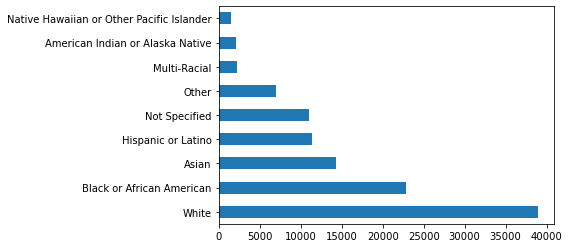

In [10]:
(df_SAP['RaceDesc'].value_counts()).plot(kind='barh')

<AxesSubplot:ylabel='Frequency'>

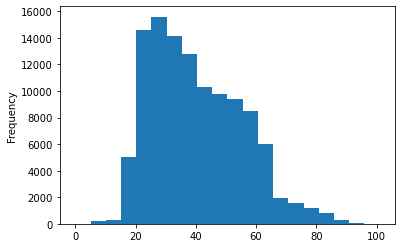

In [11]:
df_SAP['Age'].plot(kind='hist', bins=20)

<AxesSubplot:>

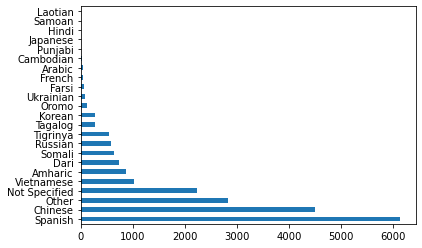

In [12]:
(df_SAP[df_SAP['LanguageSpoken']!='English']['LanguageSpoken'].value_counts()).plot(kind='barh')

In [13]:
df_SAP

,Age,RaceDesc,LanguageSpoken,Expiration,DateIssued,CardIssuingAgency,FIPS,Initial Load,Study Card,card_id,GEOID
0,36,Black or African American,Other,8/31/2019,2017-06-15,KCMCCS,5.303303e+11,NaN,NaN,568-1,53033028802
1,56,White,English,7/31/2019,2017-06-05,YWCA,5.303300e+11,NaN,NaN,2690-1,53033004000
2,58,White,English,11/30/2021,2019-08-28,King County Public Health,5.303300e+11,NaN,NaN,2690-2,53033004000
3,49,Black or African American,English,11/30/2023,2022-01-26,DSHS - ORCA LIFT (remote enrollment),5.305306e+11,10,NaN,2704-1,53053060905
4,46,Asian,English,5/31/2021,2019-06-30,King County Public Health,5.303301e+11,NaN,NaN,2706-1,53033006100
...,...,...,...,...,...,...,...,...,...,...,...
117723,26,White,English,3/31/2025,2022-03-17,King County Public Health,5.303303e+11,10,NaN,272812-1,53033030310
117724,26,Black or African American,English,3/31/2025,2022-03-17,King County Public Health,5.303300e+11,10,NaN,272814-1,53033000401
117725,52,White,English,10/31/2024,2022-03-17,King County Public Health,5.303303e+11,NaN,NaN,272816-1,53033029601
117726,58,Black or African American,English,3/31/2025,2022-03-17,King County Public Health,5.303303e+11,10,NaN,272818-1,53033028902


In [14]:
df_SAP=df_SAP[df_SAP['Initial Load']=='Subsidized Annual Pass']
df_SAP['FIPS']=(df_SAP['FIPS'].dropna().astype(int)//10)


/var/folders/41/z5_zslwx5w5gsn9clwq01bpc0000gn/T/ipykernel_18272/3808514353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SAP['FIPS']=(df_SAP['FIPS'].dropna().astype(int)//10)


In [15]:
df_SAP

,Age,RaceDesc,LanguageSpoken,Expiration,DateIssued,CardIssuingAgency,FIPS,Initial Load,Study Card,card_id,GEOID
53,52,Hispanic or Latino,English,10/31/2023,2020-12-09,King County Public Health,53033020700,Subsidized Annual Pass,NaN,2824-1,53033020700
55,53,Hispanic or Latino,English,10/31/2023,2021-11-17,King County Public Health,53033020700,Subsidized Annual Pass,NaN,2824-3,53033020700
75,67,White,English,8/31/2024,2021-04-20,DSHS - subsidized annual pass (remote enrollment),53033009000,Subsidized Annual Pass,NaN,2878-1,53033009000
80,69,White,English,7/31/2023,2020-11-16,DSHS - subsidized annual pass (remote enrollment),53033030314,Subsidized Annual Pass,NaN,2898-1,53033030314
81,70,White,English,7/31/2023,2021-12-22,DSHS - subsidized annual pass (remote enrollment),53033030314,Subsidized Annual Pass,NaN,2898-2,53033030314
...,...,...,...,...,...,...,...,...,...,...,...
117605,22,Not Specified,English,1/31/2023,2022-03-16,King County Public Health,53033021903,Subsidized Annual Pass,NaN,272576-1,53033021903
117608,29,Not Specified,English,1/31/2023,2022-03-16,King County Public Health,53033031605,Subsidized Annual Pass,NaN,272582-1,53033031605
117610,38,Other,English,1/31/2023,2022-03-16,King County Public Health,53033030004,Subsidized Annual Pass,NaN,272586-1,53033030004
117612,23,Not Specified,English,1/31/2023,2022-03-16,King County Public Health,53033028902,Subsidized Annual Pass,NaN,272590-1,53033028902


In [16]:
df_tracts.dropna(subset=['percapitapublicfunds']).sort_values('percapitapublicfunds',ascending=True).index

Int64Index([53033028801, 53033022702, 53033021300, 53033023804, 53033028402,
            53033032309, 53033005301, 53033022400, 53033029303, 53033032500,
            ...
            53033022801, 53033029004, 53033023201, 53033009200, 53033030202,
            53033030700, 53033028902, 53033030305, 53033011800, 53033030006],
           dtype='int64', name='GEOID', length=223)

In [17]:
shapefile['INTPTLAT']=pd.to_numeric(shapefile['INTPTLAT'])
shapefile['INTPTLON']=pd.to_numeric(shapefile['INTPTLON'])


In [18]:
df_plt=shapefile
df_plt['GEOID']=pd.to_numeric(df_plt['GEOID'])


In [19]:
df_plt=df_plt.merge(df_tracts, left_on='GEOID', right_on='GEOID', how='inner')

In [20]:
df_plt['pct_black']=df_plt['EstimateTotalAfricanAmerican']/df_plt['EstimateTotal']
df_plt['pct_white']=df_plt['EstimateTotalWhite']/df_plt['EstimateTotal']
df_plt['pct_asian']=df_plt['EstimateTotalAsian']/df_plt['EstimateTotal']
df_plt['pct_hispanic']=df_plt['EstimateTotalSpeakSpanish']/df_plt['EstimateTotal']
df_plt['pct_poor']=(1-df_plt['EstimateTotalAtorabove150percentofpovertylevel']/df_plt['EstimateTotal'])
df_plt['pct_very_poor']=df_plt['EstimateTotalBelow100percentofthepovertylevel']/df_plt['EstimateTotal']



In [21]:

### FOCUS AREAS BY RACIAL MAKEUP AND INCOME 

#focus1.1 --> Black population above 75 percentile & low income
df_focus1=df_plt[(df_plt['pct_black']>0.087954) & (df_plt['pct_poor']>0.187510)]
len(df_focus1)

#focus2.1 --> White population above 75 percentile & low income
df_focus2=df_plt[(df_plt['pct_white']>0.805554) & (df_plt['pct_poor']>0.187510)]


#focus3.1 --> Asian population above 75 percentile
df_focus3=df_plt[(df_plt['pct_asian']>0.223970)& (df_plt['pct_poor']>0.187510)]

#focus4.1 --> Hispanic population above 75 percentile
df_focus4=df_plt[(df_plt['pct_hispanic']>0.083673)& (df_plt['pct_poor']>0.187510)]

#focus5.1 --> very low income
df_focus5=df_plt[(df_plt['pct_very_poor']>0.106949)]

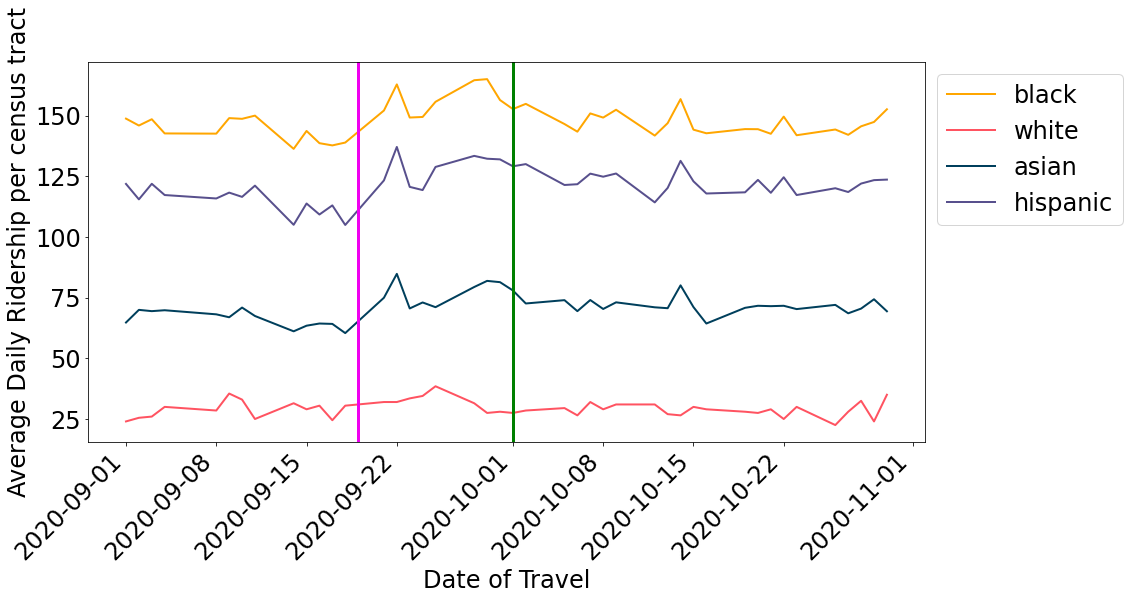

In [22]:
plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 24})
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_focus1.GEOID))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})/len(df_focus1),color='#FFA600',linewidth=2,label='black')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_focus2.GEOID))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})/len(df_focus2),color='#FF5361',linewidth=2,label='white')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_focus3.GEOID))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})/len(df_focus3),color='#003F5C',linewidth=2,label='asian')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_focus4.GEOID))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})/len(df_focus4),color='#58508D',linewidth=2,label='hispanic')
#plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_focus5.GEOID))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})/len(df_focus5),color='#BC5090',linewidth=2,label='very poor')
plt.xticks(rotation=45, ha="right")
# plt.plot(df[(df['GEOID'].isin(one)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FFA600',linewidth=2,linestyle='dashed')
# plt.plot(df[ (df['GEOID'].isin(two)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FF5361',linewidth=2,linestyle='dashed')
# plt.plot(df[(df['GEOID'].isin(three)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#003F5C',linewidth=2,linestyle='dashed')
# plt.plot(df[ (df['GEOID'].isin(four)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#58508D',linewidth=2,linestyle='dashed')

plt.axvline(x=pd.to_datetime('2020-09-19'), color='#f000f0',linewidth=3)
plt.axvline(x=pd.to_datetime('2020-10-01'), color='green',linewidth=3)
plt.xlabel('Date of Travel')
plt.ylabel('Average Daily Ridership per census tract')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

plt.show()




In [23]:

### FOCUS AREAS BY ONLY RACIAL MAKEUP

#focus1 --> Black population above 75 percentile 
df_focusA=df_plt[(df_plt['pct_black']>0.087954) ]
len(df_focus1)


#focus2 --> White population above 75 percentile 
df_focusB=df_plt[(df_plt['pct_white']>0.805554) ]


#focus3 --> Asian population above 75 percentile
df_focusC=df_plt[(df_plt['pct_asian']>0.223970)]

#focus4 --> Hispanic population above 75 percentile
df_focusD=df_plt[(df_plt['pct_hispanic']>0.083673)]







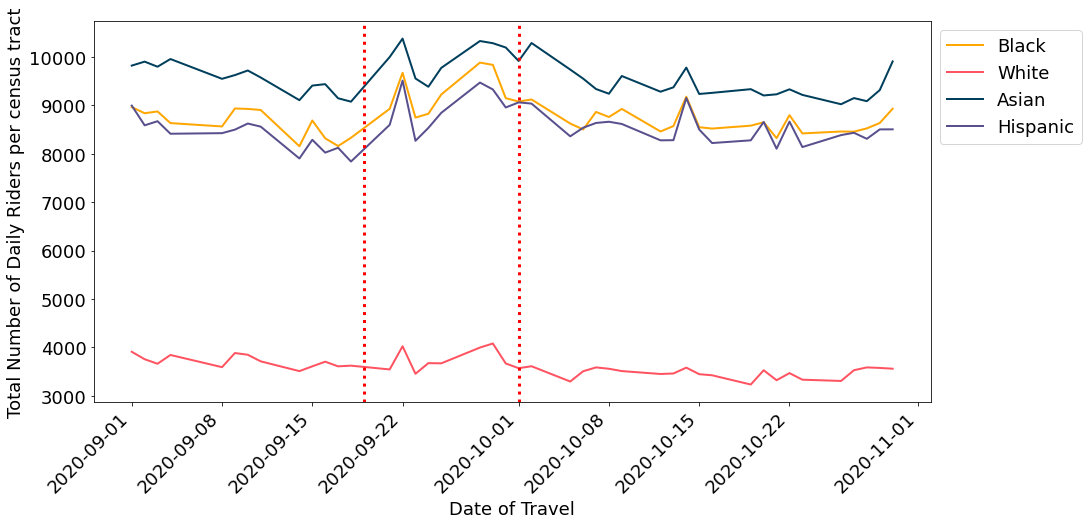

In [24]:
# plotting figure with only race as distinguishing characteristic
plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 18})
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_focusA.GEOID))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FFA600',linewidth=2,label='Black')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_focusB.GEOID))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FF5361',linewidth=2,label='White')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_focusC.GEOID))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#003F5C',linewidth=2,label='Asian')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_focusD.GEOID))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#58508D',linewidth=2,label='Hispanic')
#plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_focusE.GEOID))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#BC5090',linewidth=2,label='very poor')
plt.xticks(rotation=45, ha="right")
# plt.plot(df[(df['GEOID'].isin(one)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FFA600',linewidth=2,linestyle='dashed')
# plt.plot(df[ (df['GEOID'].isin(two)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FF5361',linewidth=2,linestyle='dashed')
# plt.plot(df[(df['GEOID'].isin(three)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#003F5C',linewidth=2,linestyle='dashed')
# plt.plot(df[ (df['GEOID'].isin(four)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#58508D',linewidth=2,linestyle='dashed')

plt.axvline(x=pd.to_datetime('2020-09-19'), color='red', ls=':',linewidth=3)
plt.axvline(x=pd.to_datetime('2020-10-01'), color='red',ls=':',linewidth=3)
plt.xlabel('Date of Travel')
plt.ylabel('Total Number of Daily Riders per census tract')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

plt.show()

#FFA600  #FF5361, #003F5C, #58508D,#BC5090

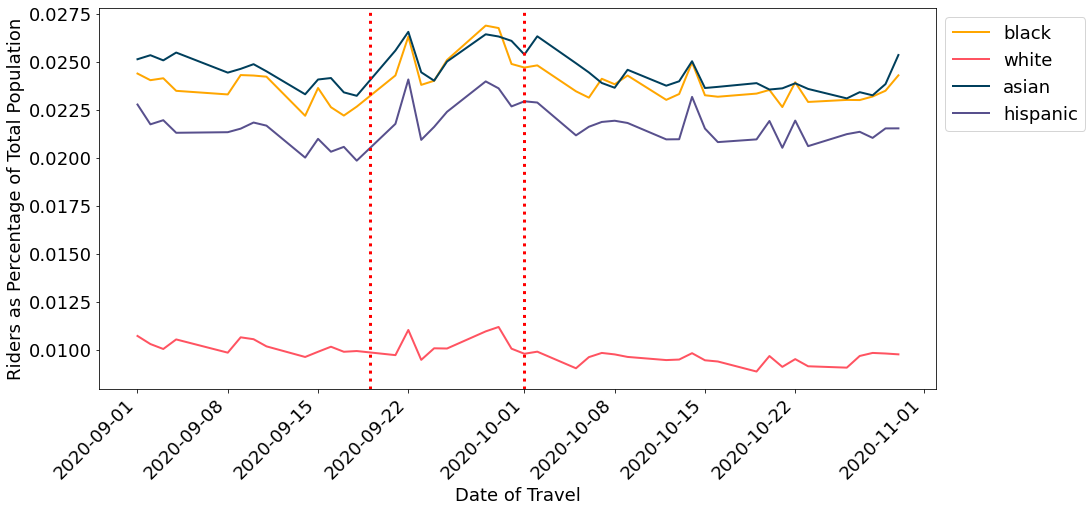

In [25]:
# plotting figure with only race as distinguishing characteristic
plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 18})
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_focusA.GEOID))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})/df_focusA.EstimateTotal.sum(),color='#FFA600',linewidth=2,label='black')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_focusB.GEOID))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})/df_focusB.EstimateTotal.sum(),color='#FF5361',linewidth=2,label='white')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_focusC.GEOID))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})/df_focusC.EstimateTotal.sum(),color='#003F5C',linewidth=2,label='asian')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_focusD.GEOID))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})/df_focusD.EstimateTotal.sum(),color= '#58508D',linewidth=2,label='hispanic')
#plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_focusE.GEOID))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#BC5090',linewidth=2,label='very poor')
plt.xticks(rotation=45, ha="right")
# plt.plot(df[(df['GEOID'].isin(one)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FFA600',linewidth=2,linestyle='dashed')
# plt.plot(df[ (df['GEOID'].isin(two)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FF5361',linewidth=2,linestyle='dashed')
# plt.plot(df[(df['GEOID'].isin(three)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#003F5C',linewidth=2,linestyle='dashed')
# plt.plot(df[ (df['GEOID'].isin(four)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#58508D',linewidth=2,linestyle='dashed')


plt.axvline(x=pd.to_datetime('2020-09-19'), color='red', ls=':',linewidth=3)
plt.axvline(x=pd.to_datetime('2020-10-01'), color='red',ls=':',linewidth=3)
plt.xlabel('Date of Travel')
plt.ylabel('Riders as Percentage of Total Population')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')



plt.show()

#FFA600  #FF5361, #003F5C, #58508D,#BC5090

In [26]:

one =list(df_plt[df_plt['pct_poor']>0.187510].GEOID) #poorest
two=list(df_plt[((df_plt['pct_poor']>0.117010) & (df_plt['pct_poor']<0.187510))].GEOID)
three=list(df_plt[((df_plt['pct_poor']>0.070689) & (df_plt['pct_poor']<0.117010))].GEOID)
four=list(df_plt[df_plt['pct_poor']<0.070689].GEOID) # richest


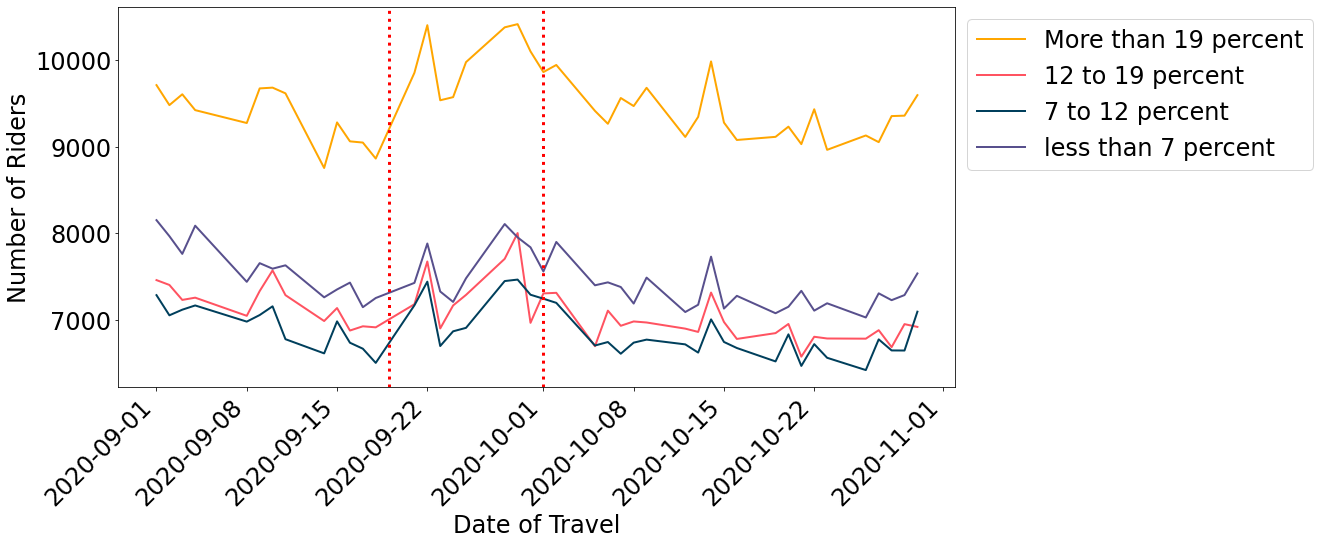

In [27]:
#figure for income groups
plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 24})
plt.xticks(rotation=45, ha="right")
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(one)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FFA600',linewidth=2,label='More than 19 percent')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(two)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FF5361',linewidth=2,label='12 to 19 percent')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(three)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#003F5C',linewidth=2,label='7 to 12 percent')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(four)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#58508D',linewidth=2,label='less than 7 percent')

# plt.plot(df_stop_activity[(df_stop_activity['GEOID'].isin(one)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FFA600',linewidth=2,linestyle='dashed')
# plt.plot(df_stop_activity[ (df_stop_activity['GEOID'].isin(two)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FF5361',linewidth=2,linestyle='dashed')
# plt.plot(df_stop_activity[(df_stop_activity['GEOID'].isin(three)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#003F5C',linewidth=2,linestyle='dashed')
# plt.plot(df_stop_activity[ (df_stop_activity['GEOID'].isin(four)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#58508D',linewidth=2,linestyle='dashed')

plt.axvline(x=pd.to_datetime('2020-09-19'), color='red',ls=':',linewidth=3)
plt.axvline(x=pd.to_datetime('2020-10-01'), color='red',ls=':',linewidth=3)
plt.xlabel('Date of Travel')
plt.ylabel('Number of Riders')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

plt.show()

#003F5C, #58508D, #BC5090, #FF5361, #FFA600

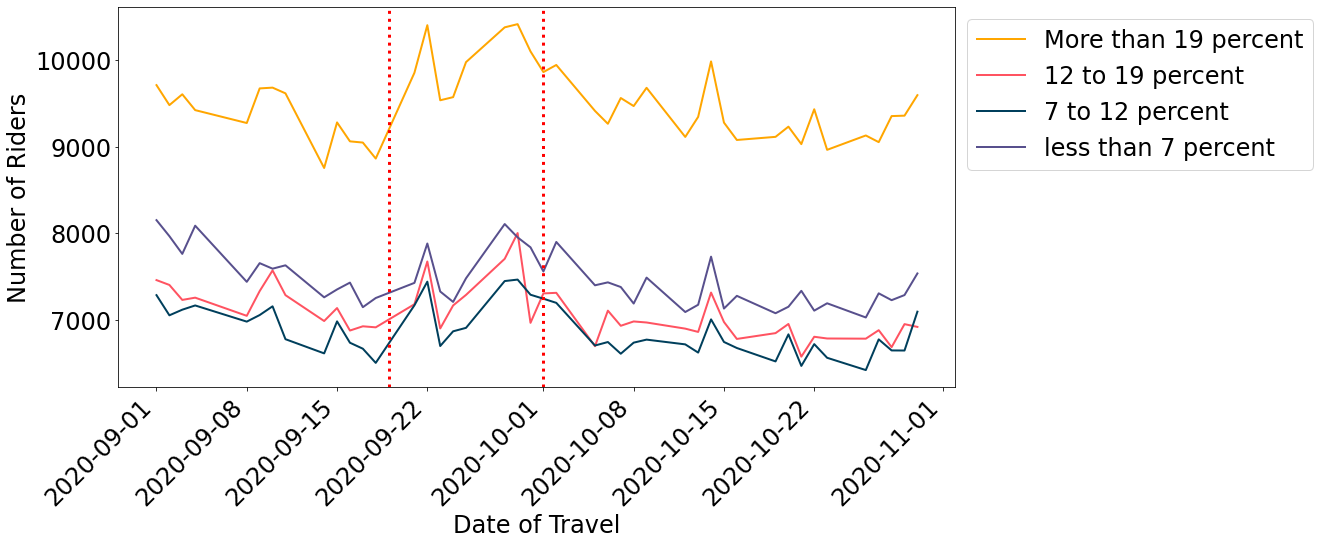

In [28]:
plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 24})
plt.xticks(rotation=45, ha="right")
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(one)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FFA600',linewidth=2,label='More than 19 percent')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(two)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FF5361',linewidth=2,label='12 to 19 percent')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(three)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#003F5C',linewidth=2,label='7 to 12 percent')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(four)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#58508D',linewidth=2,label='less than 7 percent')

# plt.plot(df_stop_activity[(df_stop_activity['GEOID'].isin(one)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FFA600',linewidth=2,linestyle='dashed')
# plt.plot(df_stop_activity[ (df_stop_activity['GEOID'].isin(two)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FF5361',linewidth=2,linestyle='dashed')
# plt.plot(df_stop_activity[(df_stop_activity['GEOID'].isin(three)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#003F5C',linewidth=2,linestyle='dashed')
# plt.plot(df_stop_activity[ (df_stop_activity['GEOID'].isin(four)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#58508D',linewidth=2,linestyle='dashed')

plt.axvline(x=pd.to_datetime('2020-09-19'), color='red',ls=':',linewidth=3)
plt.axvline(x=pd.to_datetime('2020-10-01'), color='red',ls=':',linewidth=3)
plt.xlabel('Date of Travel')
plt.ylabel('Number of Riders')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

plt.show()


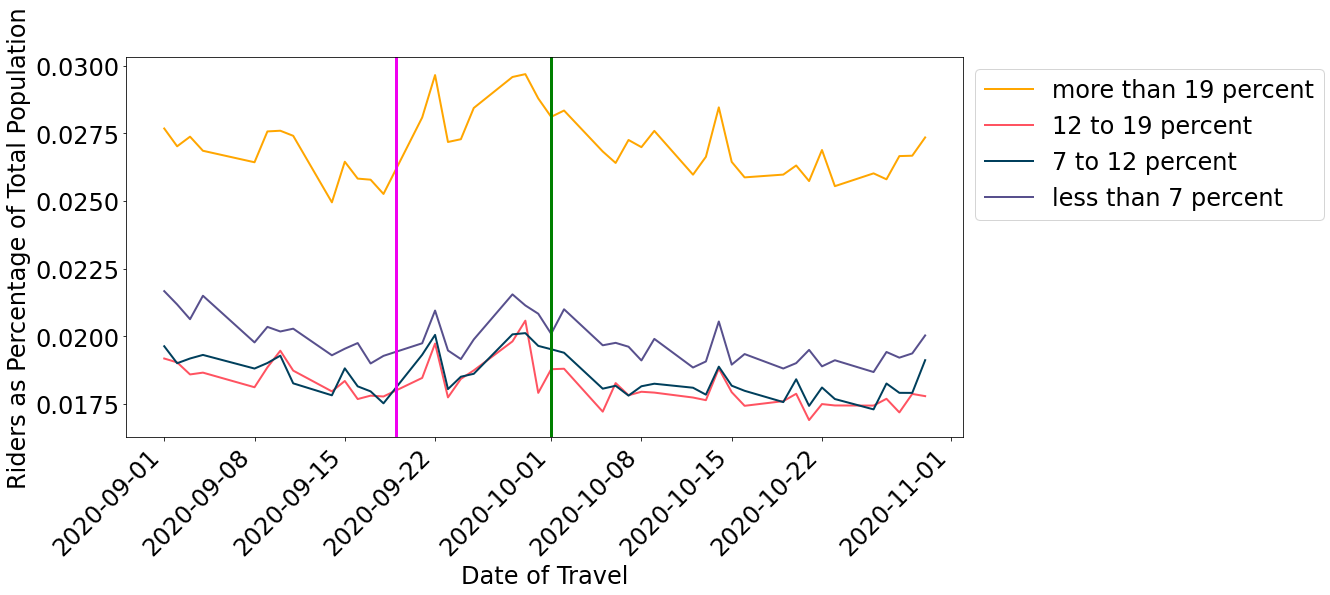

In [29]:
#figure for income groups
plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 24})
plt.xticks(rotation=45, ha="right")
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(one)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})/df_plt[df_plt.GEOID.isin(one)].EstimateTotal.sum(),color='#FFA600',linewidth=2,label='more than 19 percent')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(two)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})/df_plt[df_plt.GEOID.isin(two)].EstimateTotal.sum(),color='#FF5361',linewidth=2,label='12 to 19 percent')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(three)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})/df_plt[df_plt.GEOID.isin(three)].EstimateTotal.sum(),color='#003F5C',linewidth=2,label='7 to 12 percent')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(four)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})/df_plt[df_plt.GEOID.isin(four)].EstimateTotal.sum(),color='#58508D',linewidth=2,label='less than 7 percent')

# plt.plot(df_stop_activity[(df_stop_activity['GEOID'].isin(one)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FFA600',linewidth=2,linestyle='dashed')
# plt.plot(df_stop_activity[ (df_stop_activity['GEOID'].isin(two)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FF5361',linewidth=2,linestyle='dashed')
# plt.plot(df_stop_activity[(df_stop_activity['GEOID'].isin(three)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#003F5C',linewidth=2,linestyle='dashed')
# plt.plot(df_stop_activity[ (df_stop_activity['GEOID'].isin(four)) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#58508D',linewidth=2,linestyle='dashed')

plt.axvline(x=pd.to_datetime('2020-09-19'), color='#f000f0',linewidth=3)
plt.axvline(x=pd.to_datetime('2020-10-01'), color='green',linewidth=3)
plt.xlabel('Date of Travel')
plt.ylabel('Riders as Percentage of Total Population')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

plt.show()

#003F5C, #58508D, #BC5090, #FF5361, #FFA600

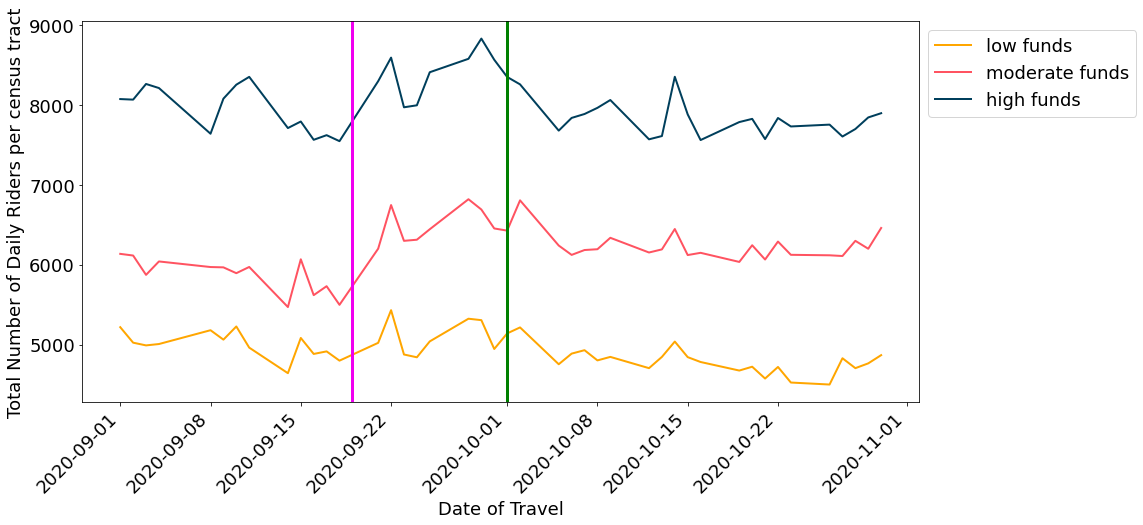

In [30]:
# plotting figure with public funds as distinguishing characteristic
plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 18})
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_tracts['percapitapublicfunds'].dropna().sort_values().index[:70]))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FFA600',linewidth=2,label='low funds')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_tracts['percapitapublicfunds'].dropna().sort_values().index[70:150]))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#FF5361',linewidth=2,label='moderate funds')
plt.plot(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & (df_stop_activity['GEOID'].isin(list(df_tracts['percapitapublicfunds'].dropna().sort_values().index[150:223]))) ].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'}),color='#003F5C',linewidth=2,label='high funds')

plt.xticks(rotation=45, ha="right")

plt.axvline(x=pd.to_datetime('2020-09-19'), color='#f000f0',linewidth=3)
plt.axvline(x=pd.to_datetime('2020-10-01'), color='green',linewidth=3)
plt.xlabel('Date of Travel')
plt.ylabel('Total Number of Daily Riders per census tract')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

plt.show()

<h3>Difference-in-Differences

In [31]:
def statcalc(focus):
    fare_ch_dt='2020-10-01'
    rt_ch_dt='2020-09-19'
    pre_rt=df_stop_activity[(df_stop_activity['OPERATION_DATE']<=rt_ch_dt)&(df_stop_activity['GEOID'].isin(list(focus)))].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})
    post_fare=df_stop_activity[(df_stop_activity['OPERATION_DATE']>=fare_ch_dt) & (df_stop_activity['GEOID'].isin(list(focus)))].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})
    post_rt=df_stop_activity[(df_stop_activity['OPERATION_DATE']<fare_ch_dt) & (df_stop_activity['OPERATION_DATE']>rt_ch_dt) & (df_stop_activity['GEOID'].isin(list(focus)))].groupby(['OPERATION_DATE']).agg({'PSNGR_BOARDINGS':'sum'})
    population=df_tracts[df_tracts.index.isin(focus)]['EstimateTotal'].sum()
    print(population)
    return pre_rt['PSNGR_BOARDINGS'].mean(),post_rt['PSNGR_BOARDINGS'].mean(),post_fare['PSNGR_BOARDINGS'].mean()


In [32]:
statcalc( list(df_plt.GEOID)) # ABCD, Black,White,Asian,Hispanic

394905


(7339.222222222223, 7721.272727272727, 7277.0)

In [30]:
def diff_ofdiffs(focus1, focus2):
    _,mid,post=statcalc(focus1)
    _,mid2,post2=statcalc(focus2)
    diffOfdiffs=pd.DataFrame()
    diffOfdiffs['Focus1']=[mid,post,post-mid]
    diffOfdiffs['Focus2']=[mid2,post2,post2-mid2]
    diffOfdiffs['Difference']=    diffOfdiffs['Focus2'] -  diffOfdiffs['Focus1']
    return diffOfdiffs

<h4>Determining Control Groups 

In [33]:
# first control set of GEOIDs are those where riders had subsidized annual passes and so fare reinstatement should not hurt them
control1=list(df_SAP.groupby('GEOID').count()['Age'].sort_values(ascending=False)[:20].index)

# second control is downtown Seattle census tracts where fares were not imposed historically and fare aversion continues to be high

control2=list(df_plt[(df_plt['INTPTLAT']<=47.66) & (df_plt['INTPTLAT']>=47.58) &(df_plt['INTPTLON']>-122.37) &(df_plt['INTPTLON']<-122.32)].GEOID)
control2=list(set(control2)-set(control2).intersection(set(control1)))

# third control is Seattle census tracts with highest income residents
control3=list(df_plt[df_plt['richest']>0.14].GEOID)
control3=list(set(control3)-set(control2).intersection(set(control3)-set(control1).intersection(set(control3))))



367506
219048


<AxesSubplot:>

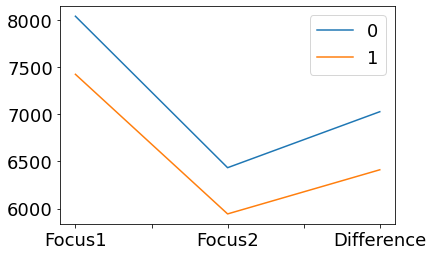

In [31]:
f=diff_ofdiffs(list(df_focusA.GEOID), list(df_focus1.GEOID))
f=f.T
f.iloc[2]=f.iloc[0]-1010.545455
f=f.drop(2, axis=1)
f.plot()

In [34]:
statcalc(one)

350878


(8171.444444444444, 8783.90909090909, 8101.548387096775)

<h3>Difference in Differences with Synthetic Controls</h3>

<h4>Control 1 with income group very poor</h4>

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


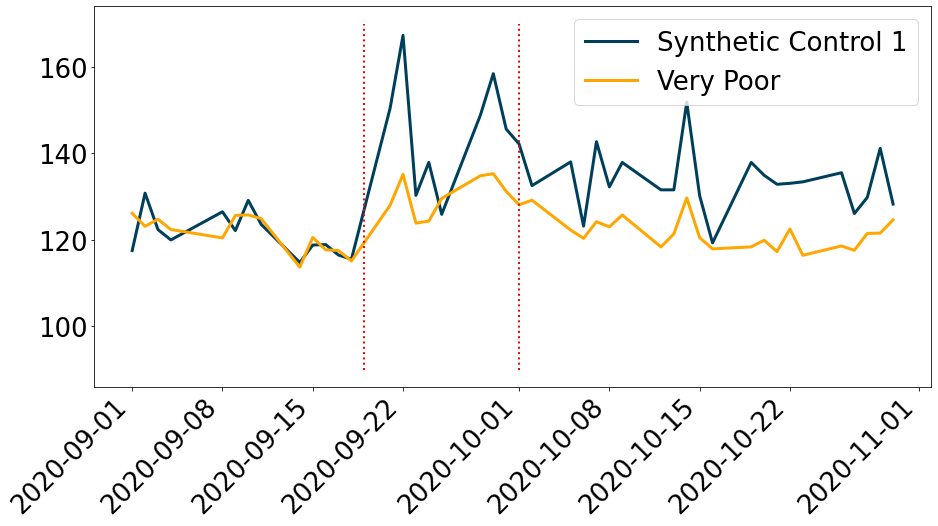

In [55]:
tempX=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempX=tempX[tempX.GEOID.isin(control1)]

tempX=tempX.iloc[:,1:].div(tempX.EstimateTotal, axis=0)
tempX.index=tempX.GEOID
tempX=tempX.drop('GEOID',axis=1).T


tempY=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempY=tempY[tempY.GEOID.isin(one)]
tempY.index=tempY.GEOID
tempY
tempY=tempY.iloc[:,1:].div(tempY.EstimateTotal, axis=0)
tempY=tempY.drop('GEOID',axis=1).T.mean(axis=1)

from sklearn.linear_model import LinearRegression

reg=LinearRegression(positive=True, fit_intercept=False).fit(tempX,tempY)

inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(control1))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(one)], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS/len(one)
inv=inv*reg.coef_[:-1]
inv=inv.dropna(axis=1)
X=inv[:13] # control ridership
y= other[:13]# mean target ridership

# weights_lr=get_w(X, y)
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False, positive=True).fit(X, y).coef_
weights_lr.round(3)

plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 26})
plt.plot(inv.dot(weights_lr),label='Synthetic Control 1',color='#003F5C',linewidth=3)
plt.plot(other,label='Very Poor',color='#FFA600',linewidth=3)
plt.vlines(x=pd.to_datetime('2020/09/19'), ymin=90, ymax=170, linestyle=":",color='r', lw=2)
plt.vlines(x=pd.to_datetime('2020/10/1'), ymin=90, ymax=170, linestyle=":",color='r', lw=2)
plt.xticks(rotation=45, ha="right")
plt.legend();


plt.legend(loc='upper right')

#003F5C, #58508D, #BC5090, #FF5361, #FFA600

plt.show()

<h4>Control 2 with income group very poor</h4>

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


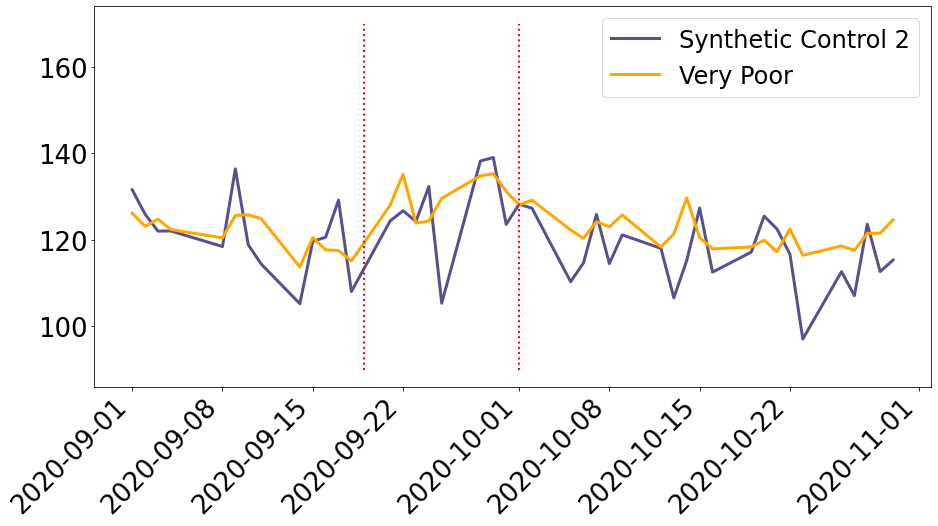

In [56]:
tempX=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempX=tempX[tempX.GEOID.isin(control2)]

tempX=tempX.iloc[:,1:].div(tempX.EstimateTotal, axis=0)
tempX.index=tempX.GEOID
tempX=tempX.drop('GEOID',axis=1).T


tempY=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempY=tempY[tempY.GEOID.isin(one)]
tempY.index=tempY.GEOID
tempY
tempY=tempY.iloc[:,1:].div(tempY.EstimateTotal, axis=0)
tempY=tempY.drop('GEOID',axis=1).T.mean(axis=1)

from sklearn.linear_model import LinearRegression

reg=LinearRegression(positive=True, fit_intercept=False).fit(tempX,tempY)

inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(control2))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(one)], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS/len(one)
inv=inv*reg.coef_
inv=inv.dropna(axis=1)
X=inv[:13] # control ridership
y= other[:13]# mean target ridership

# weights_lr=get_w(X, y)
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False, positive=True).fit(X, y).coef_
weights_lr.round(3)

plt.figure(figsize=(15,7))
plt.plot(inv.dot(weights_lr),label='Synthetic Control 2',color='#58508D',linewidth=3)
plt.plot(other,label='Very Poor',color='#FFA600',linewidth=3)
plt.vlines(x=pd.to_datetime('2020/09/19'), ymin=90, ymax=170, linestyle=":",color='r', lw=2)
plt.vlines(x=pd.to_datetime('2020/10/1'), ymin=90, ymax=170, linestyle=":",color='r', lw=2)
plt.xticks(rotation=45, ha="right")


plt.rcParams.update({'font.size': 24})

plt.legend(loc='upper right')

#003F5C, #58508D, #BC5090, #FF5361, #FFA600

plt.show()

<h4>Control 3  with income group very poor</h4>

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


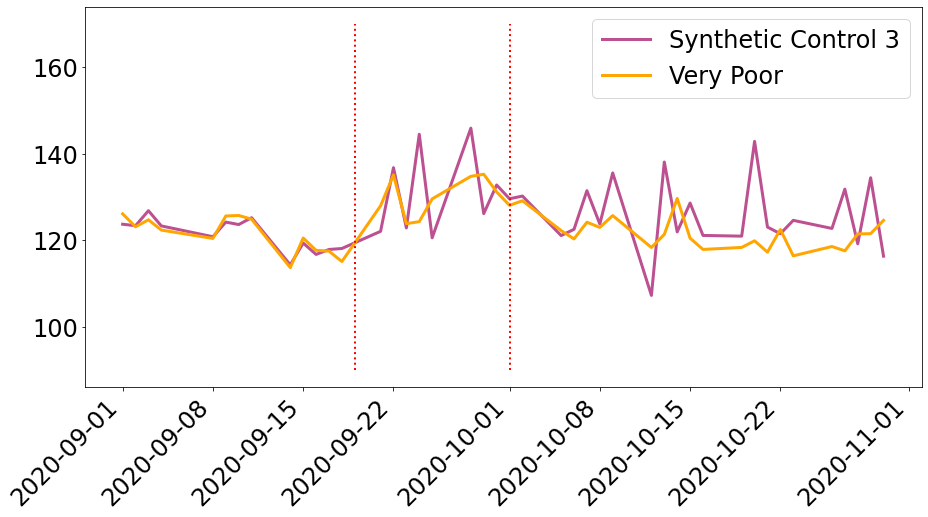

In [57]:
tempX=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempX=tempX[tempX.GEOID.isin(control3)]

tempX=tempX.iloc[:,1:].div(tempX.EstimateTotal, axis=0)
tempX.index=tempX.GEOID
tempX=tempX.drop('GEOID',axis=1).T


tempY=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempY=tempY[tempY.GEOID.isin(one)]
tempY.index=tempY.GEOID
tempY
tempY=tempY.iloc[:,1:].div(tempY.EstimateTotal, axis=0)
tempY=tempY.drop('GEOID',axis=1).T.mean(axis=1)

from sklearn.linear_model import LinearRegression

reg=LinearRegression(positive=True, fit_intercept=False).fit(tempX,tempY)

inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(control3))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(one)], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS/len(one)

# inv=inv*reg.coef_[:-9]
inv=inv.dropna(axis=1)
X=inv[:13] # control ridership
y= other[:13]# mean target ridership

# weights_lr=get_w(X, y)
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False, positive=True).fit(X, y).coef_
weights_lr.round(3)

plt.figure(figsize=(15,7))
plt.plot(inv.dot(weights_lr),label='Synthetic Control 3',color='#BC5090',lw=3)
plt.plot(other,label='Very Poor',color='#FFA600',linewidth=3)
plt.vlines(x=pd.to_datetime('2020/09/19'), ymin=90, ymax=170, linestyle=":",color='r', lw=2)
plt.vlines(x=pd.to_datetime('2020/10/1'), ymin=90, ymax=170, linestyle=":",color='r', lw=2)
plt.xticks(rotation=45, ha="right")

plt.legend(loc='upper right')
plt.legend();
plt.show()

<h4>Control 1 with race group black</h4>

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


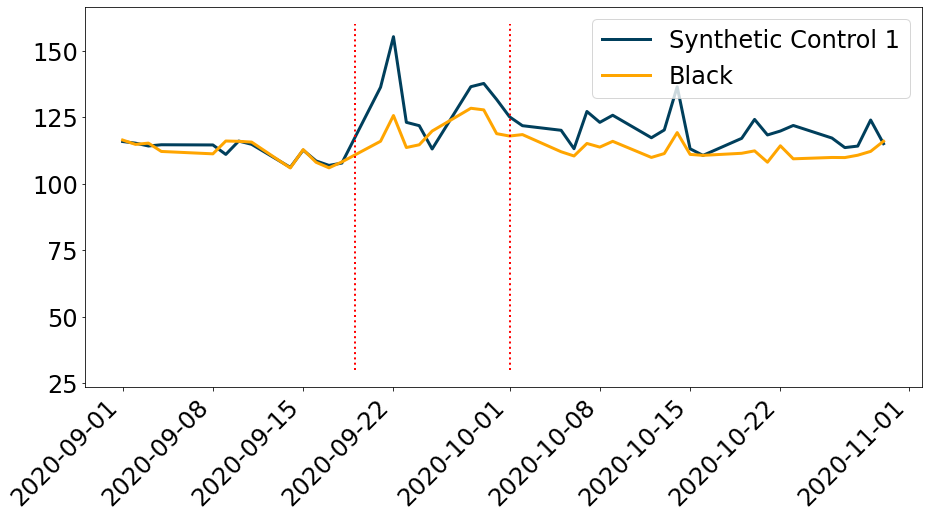

In [58]:
tempX=df_plt[['GEOID','pct_black','pct_white','pct_asian','pct_hispanic']]
tempX=tempX[tempX.GEOID.isin(control1)]

tempX.index=tempX.GEOID
tempX=tempX.drop('GEOID',axis=1).T


tempY=df_plt[['GEOID','pct_black','pct_white','pct_asian','pct_hispanic']]
tempY=tempY[tempY.GEOID.isin(df_focusA.GEOID)]
tempY.index=tempY.GEOID
tempY
tempY=tempY.drop('GEOID',axis=1).T.mean(axis=1)

from sklearn.linear_model import LinearRegression

reg=LinearRegression(positive=True, fit_intercept=False).fit(tempX,tempY)

inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(control1))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(df_focusA.GEOID)], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS/len(df_focusA.GEOID)
#inv=inv*reg.coef_[:-1]
inv=inv.dropna(axis=1)
X=inv[:13] # control ridership
y= other[:13]# mean target ridership

# weights_lr=get_w(X, y)
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False, positive=True).fit(X, y).coef_
weights_lr.round(3)

plt.figure(figsize=(15,7))
plt.plot(inv.dot(weights_lr),label='Synthetic Control 1',color='#003F5C',linewidth=3)
plt.plot(other,label='Black',color='orange',linewidth=3)
plt.vlines(x=pd.to_datetime('2020/09/19'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.vlines(x=pd.to_datetime('2020/10/1'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper right');
plt.show()


<h4>Control 2 with race group black</h4>

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


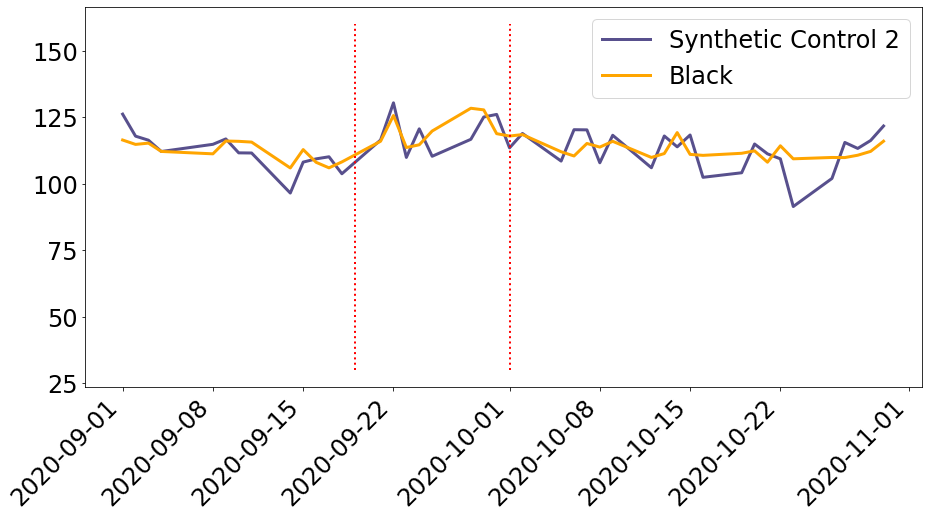

In [59]:
tempX=df_plt[['GEOID','pct_black','pct_white','pct_asian','pct_hispanic']]
tempX=tempX[tempX.GEOID.isin(control2)]

tempX.index=tempX.GEOID
tempX=tempX.drop('GEOID',axis=1).T


tempY=df_plt[['GEOID','pct_black','pct_white','pct_asian','pct_hispanic']]
tempY=tempY[tempY.GEOID.isin(df_focusA.GEOID)]
tempY.index=tempY.GEOID
tempY
tempY=tempY.drop('GEOID',axis=1).T.mean(axis=1)

from sklearn.linear_model import LinearRegression

reg=LinearRegression(positive=True, fit_intercept=False).fit(tempX,tempY)

inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(control2))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(df_focusA.GEOID)], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS/len(df_focusA.GEOID)
#inv=inv*reg.coef_
inv=inv.dropna(axis=1)
X=inv[:13] # control ridership
y= other[:13]# mean target ridership

# weights_lr=get_w(X, y)
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False, positive=True).fit(X, y).coef_
weights_lr.round(3)

plt.figure(figsize=(15,7))
plt.plot(inv.dot(weights_lr),label='Synthetic Control 2',color='#58508D',linewidth=3)
plt.plot(other,label='Black',color='orange',linewidth=3)
plt.vlines(x=pd.to_datetime('2020/09/19'), ymin=30, ymax=160, linestyle=":",color='r', lw=2) 
plt.vlines(x=pd.to_datetime('2020/10/1'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper right')
plt.show()

<h4>Control 3 with race group black</h4>

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


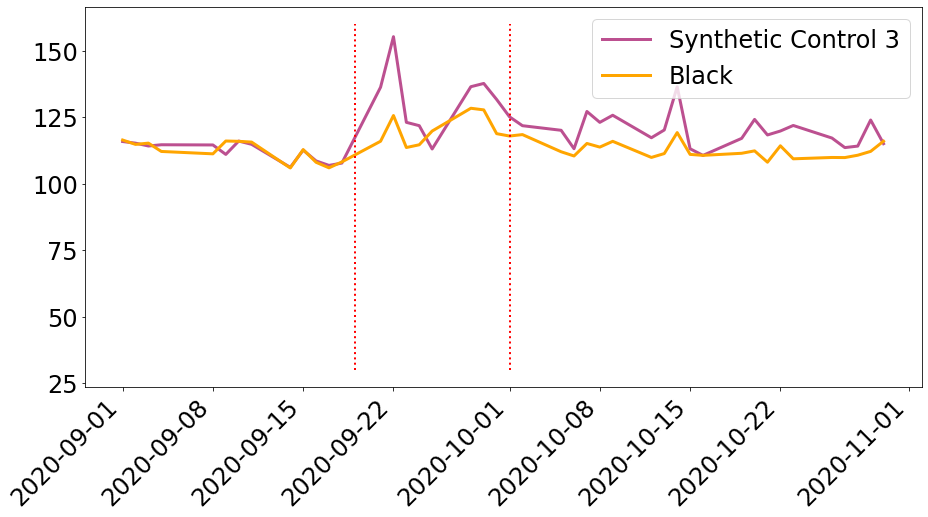

In [60]:
tempX=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempX=tempX[tempX.GEOID.isin(control3)]

tempX=tempX.iloc[:,1:].div(tempX.EstimateTotal, axis=0)
tempX.index=tempX.GEOID
tempX=tempX.drop('GEOID',axis=1).T


tempY=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempY=tempY[tempY.GEOID.isin(df_focusA.GEOID)]
tempY.index=tempY.GEOID
tempY
tempY=tempY.iloc[:,1:].div(tempY.EstimateTotal, axis=0)
tempY=tempY.drop('GEOID',axis=1).T.mean(axis=1)

from sklearn.linear_model import LinearRegression

reg=LinearRegression(positive=True, fit_intercept=False).fit(tempX,tempY)

inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(control1))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(df_focusA.GEOID)], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS/len(df_focusA.GEOID)
#inv=inv*reg.coef_[:-1]
inv=inv.dropna(axis=1)
X=inv[:13] # control ridership
y= other[:13]# mean target ridership

# weights_lr=get_w(X, y)
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False, positive=True).fit(X, y).coef_
weights_lr.round(3)

plt.figure(figsize=(15,7))
plt.plot(inv.dot(weights_lr),label='Synthetic Control 3',color='#BC5090',lw=3)
plt.plot(other,label='Black',color='orange',linewidth=3)
plt.vlines(x=pd.to_datetime('2020/09/19'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.vlines(x=pd.to_datetime('2020/10/1'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper right')
plt.show()

<h4>Control 1 with race group white</h4>

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


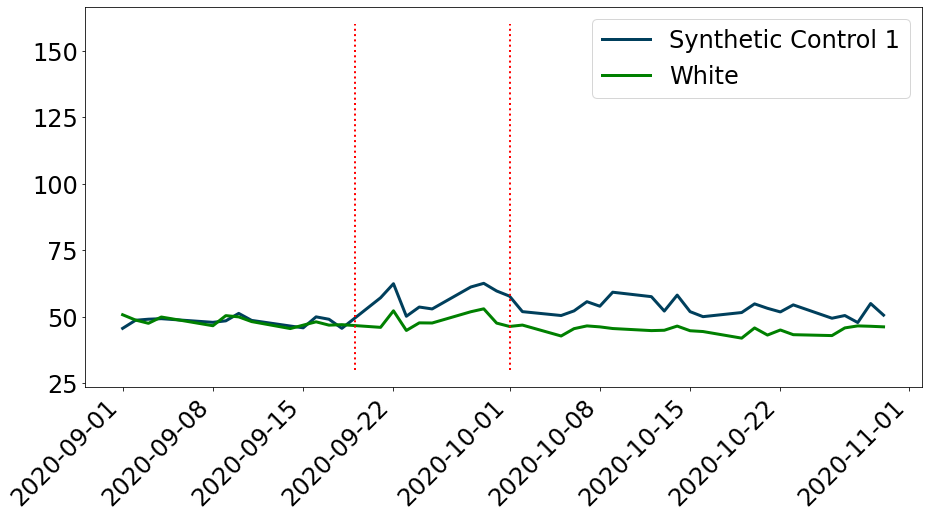

In [61]:
tempX=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempX=tempX[tempX.GEOID.isin(control1)]

tempX=tempX.iloc[:,1:].div(tempX.EstimateTotal, axis=0)
tempX.index=tempX.GEOID
tempX=tempX.drop('GEOID',axis=1).T


tempY=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempY=tempY[tempY.GEOID.isin(df_focusB.GEOID)]
tempY.index=tempY.GEOID
tempY
tempY=tempY.iloc[:,1:].div(tempY.EstimateTotal, axis=0)
tempY=tempY.drop('GEOID',axis=1).T.mean(axis=1)

from sklearn.linear_model import LinearRegression

reg=LinearRegression(positive=True, fit_intercept=False).fit(tempX,tempY)

inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(control1))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(df_focusB.GEOID)], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS/len(df_focusB.GEOID)
inv=inv*reg.coef_[:-1]
inv=inv.dropna(axis=1)
X=inv[:13] # control ridership
y= other[:13]# mean target ridership

# weights_lr=get_w(X, y)
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False, positive=True).fit(X, y).coef_
weights_lr.round(3)

plt.figure(figsize=(15,7))
plt.plot(inv.dot(weights_lr),label='Synthetic Control 1',color='#003F5C',linewidth=3)
plt.plot(other,label='White',color='green',lw=3)
plt.vlines(x=pd.to_datetime('2020/09/19'), ymin=30, ymax=160, linestyle=":", lw=2,color='r')
plt.vlines(x=pd.to_datetime('2020/10/1'), ymin=30, ymax=160, linestyle=":", lw=2,color='r')
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper right')
plt.show()

<h4>Control 2 with race group white</h4>

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


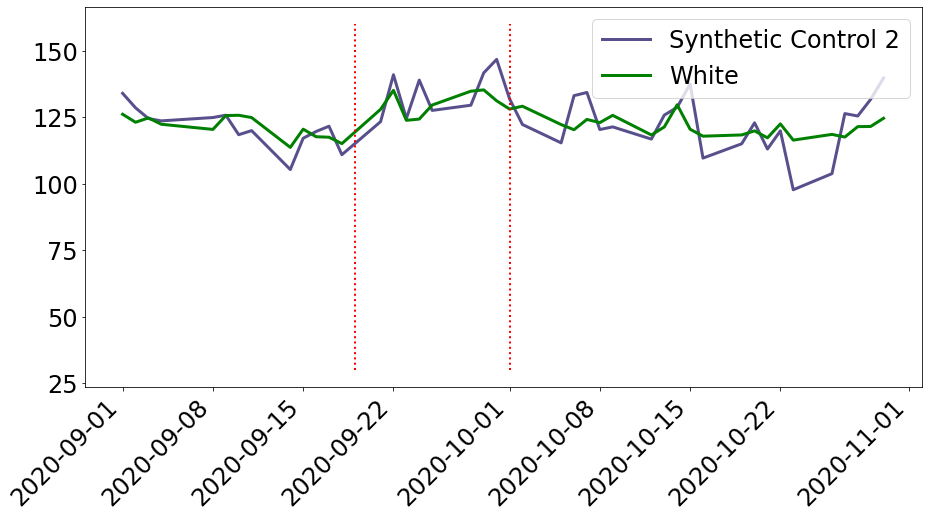

In [62]:
tempX=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempX=tempX[tempX.GEOID.isin(control2)]

tempX=tempX.iloc[:,1:].div(tempX.EstimateTotal, axis=0)
tempX.index=tempX.GEOID
tempX=tempX.drop('GEOID',axis=1).T


tempY=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempY=tempY[tempY.GEOID.isin(df_focusB.GEOID)]
tempY.index=tempY.GEOID
tempY
tempY=tempY.iloc[:,1:].div(tempY.EstimateTotal, axis=0)
tempY=tempY.drop('GEOID',axis=1).T.mean(axis=1)

from sklearn.linear_model import LinearRegression

reg=LinearRegression(positive=True, fit_intercept=False).fit(tempX,tempY)

inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(control2))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(one)], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS/len(df_focusB.GEOID)
inv=inv*reg.coef_
inv=inv.dropna(axis=1)
X=inv[:13] # control ridership
y= other[:13]# mean target ridership

# weights_lr=get_w(X, y)
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False, positive=True).fit(X, y).coef_
weights_lr.round(3)

plt.figure(figsize=(15,7))
plt.plot(inv.dot(weights_lr),label='Synthetic Control 2',color='#58508D',linewidth=3)
plt.plot(other,label='White',lw=3,color='green')
plt.vlines(x=pd.to_datetime('2020/09/19'), ymin=30, ymax=160, linestyle=":", lw=2,color='r')
plt.vlines(x=pd.to_datetime('2020/10/1'), ymin=30, ymax=160, linestyle=":", lw=2,color='r')
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper right')
plt.show()

<h4>Control 3 with race group white</h4>

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


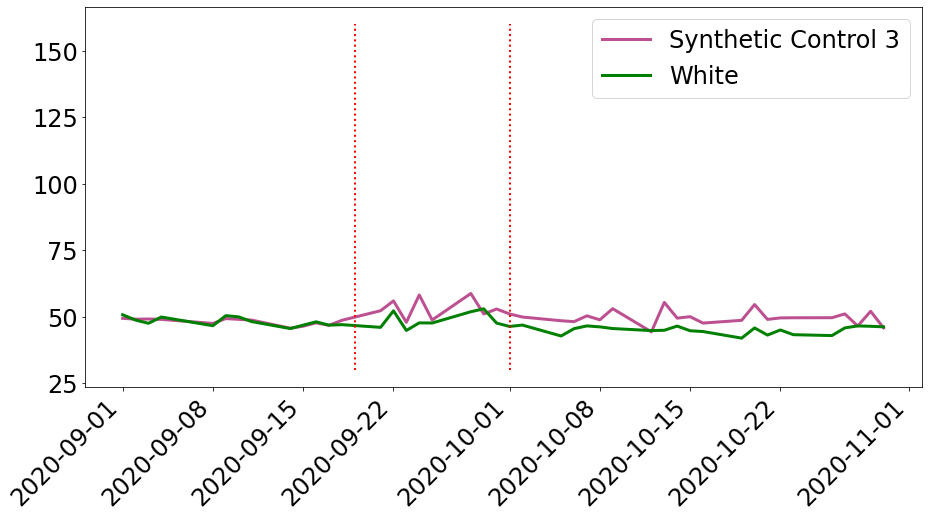

In [63]:
tempX=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempX=tempX[tempX.GEOID.isin(control3)]

tempX=tempX.iloc[:,1:].div(tempX.EstimateTotal, axis=0)
tempX.index=tempX.GEOID
tempX=tempX.drop('GEOID',axis=1).T


tempY=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempY=tempY[tempY.GEOID.isin(df_focusB.GEOID)]
tempY.index=tempY.GEOID
tempY
tempY=tempY.iloc[:,1:].div(tempY.EstimateTotal, axis=0)
tempY=tempY.drop('GEOID',axis=1).T.mean(axis=1)

from sklearn.linear_model import LinearRegression

reg=LinearRegression(positive=True, fit_intercept=False).fit(tempX,tempY)

inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(control3))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(df_focusB.GEOID)], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS/len(df_focusB.GEOID)
#inv=inv*reg.coef_[:-1]
inv=inv.dropna(axis=1)
X=inv[:13] # control ridership
y= other[:13]# mean target ridership

# weights_lr=get_w(X, y)
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False, positive=True).fit(X, y).coef_
weights_lr.round(3)

plt.figure(figsize=(15,7))
plt.plot(inv.dot(weights_lr),label='Synthetic Control 3',color='#BC5090',lw=3)
plt.plot(other,label='White',color='green',lw=3)
plt.vlines(x=pd.to_datetime('2020/09/19'), ymin=30, ymax=160, linestyle=":", lw=2,color='r')
plt.vlines(x=pd.to_datetime('2020/10/1'), ymin=30, ymax=160, linestyle=":", lw=2,color='r')
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper right')
plt.show()

<h4>Control 1 with race group asian</h4>

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


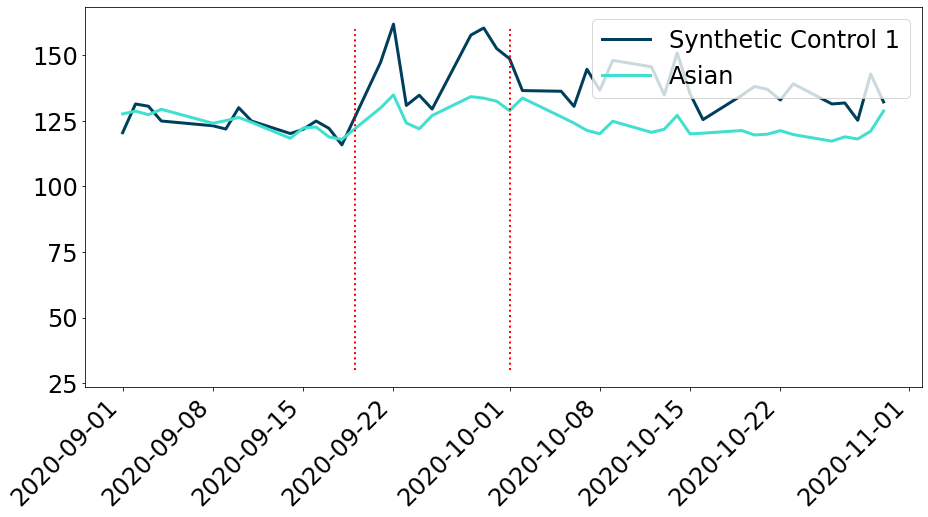

In [64]:
tempX=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempX=tempX[tempX.GEOID.isin(control1)]

tempX=tempX.iloc[:,1:].div(tempX.EstimateTotal, axis=0)
tempX.index=tempX.GEOID
tempX=tempX.drop('GEOID',axis=1).T


tempY=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempY=tempY[tempY.GEOID.isin(df_focusC.GEOID)]
tempY.index=tempY.GEOID
tempY
tempY=tempY.iloc[:,1:].div(tempY.EstimateTotal, axis=0)
tempY=tempY.drop('GEOID',axis=1).T.mean(axis=1)

from sklearn.linear_model import LinearRegression

reg=LinearRegression(positive=True, fit_intercept=False).fit(tempX,tempY)

inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(control1))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(df_focusC.GEOID)], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS/len(df_focusC.GEOID)
inv=inv*reg.coef_[:-1]
inv=inv.dropna(axis=1)
X=inv[:13] # control ridership
y= other[:13]# mean target ridership

# weights_lr=get_w(X, y)
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False, positive=True).fit(X, y).coef_
weights_lr.round(3)

plt.figure(figsize=(15,7))
plt.plot(inv.dot(weights_lr),label='Synthetic Control 1',color='#003F5C',linewidth=3)
plt.plot(other,label='Asian',color='#40E0D0',lw=3)
plt.vlines(x=pd.to_datetime('2020/09/19'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.vlines(x=pd.to_datetime('2020/10/1'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper right')
plt.show()

<h4>Control 2 with race group asian</h4>

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


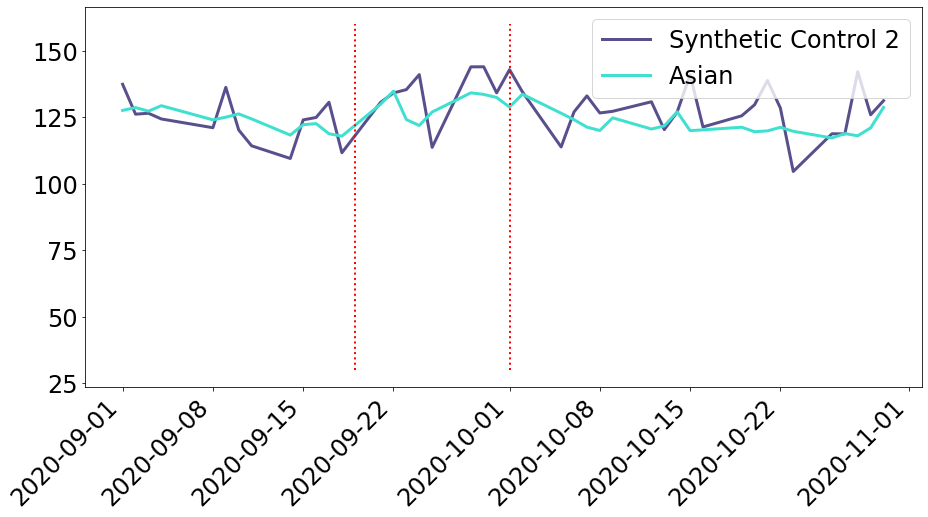

In [65]:
tempX=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempX=tempX[tempX.GEOID.isin(control2)]

tempX=tempX.iloc[:,1:].div(tempX.EstimateTotal, axis=0)
tempX.index=tempX.GEOID
tempX=tempX.drop('GEOID',axis=1).T


tempY=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempY=tempY[tempY.GEOID.isin(df_focusC.GEOID)]
tempY.index=tempY.GEOID
tempY
tempY=tempY.iloc[:,1:].div(tempY.EstimateTotal, axis=0)
tempY=tempY.drop('GEOID',axis=1).T.mean(axis=1)

from sklearn.linear_model import LinearRegression

reg=LinearRegression(positive=True, fit_intercept=False).fit(tempX,tempY)

inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(control2))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(df_focusC.GEOID)], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS/len(df_focusC.GEOID)
inv=inv*reg.coef_
inv=inv.dropna(axis=1)
X=inv[:13] # control ridership
y= other[:13]# mean target ridership

# weights_lr=get_w(X, y)
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False, positive=True).fit(X, y).coef_
weights_lr.round(3)

plt.figure(figsize=(15,7))
plt.plot(inv.dot(weights_lr),label='Synthetic Control 2',color='#58508D',linewidth=3)
plt.plot(other,label='Asian',color='#40E0D0',lw=3)
plt.vlines(x=pd.to_datetime('2020/09/19'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.vlines(x=pd.to_datetime('2020/10/1'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper right')
plt.show()

<h4>Control 3 with race group asian</h4>

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


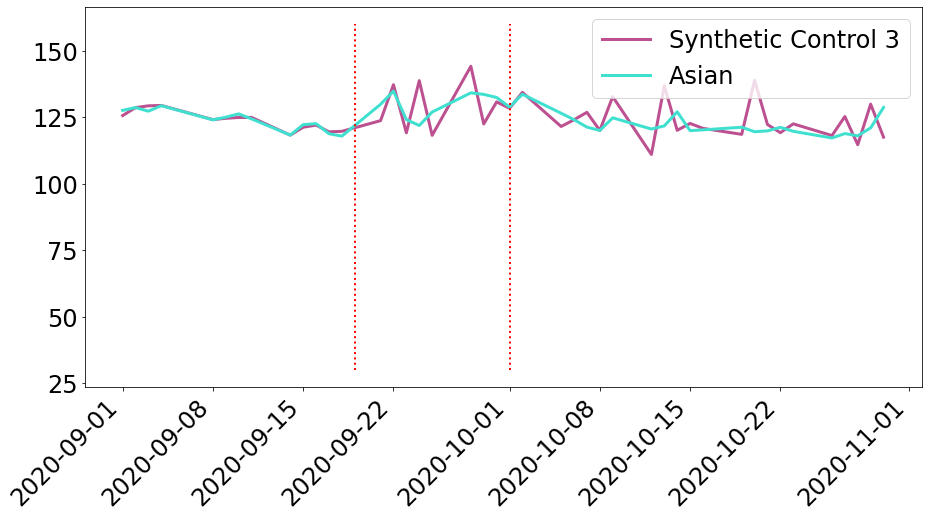

In [66]:
tempX=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempX=tempX[tempX.GEOID.isin(control3)]

tempX=tempX.iloc[:,1:].div(tempX.EstimateTotal, axis=0)
tempX.index=tempX.GEOID
tempX=tempX.drop('GEOID',axis=1).T


tempY=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempY=tempY[tempY.GEOID.isin(one)]
tempY.index=tempY.GEOID
tempY
tempY=tempY.iloc[:,1:].div(tempY.EstimateTotal, axis=0)
tempY=tempY.drop('GEOID',axis=1).T.mean(axis=1)

from sklearn.linear_model import LinearRegression

reg=LinearRegression(positive=True, fit_intercept=False).fit(tempX,tempY)

inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(control3))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(df_focusC.GEOID)], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS/len(df_focusC.GEOID)
# inv=inv*reg.coef_[:-1]
inv=inv.dropna(axis=1)
X=inv[:13] # control ridership
y= other[:13]# mean target ridership

# weights_lr=get_w(X, y)
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False, positive=True).fit(X, y).coef_
weights_lr.round(3)

plt.figure(figsize=(15,7))
plt.plot(inv.dot(weights_lr),label='Synthetic Control 3',color='#BC5090',lw=3)
plt.plot(other,label='Asian', color='#40E0D0',lw=3)
plt.vlines(x=pd.to_datetime('2020/09/19'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.vlines(x=pd.to_datetime('2020/10/1'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper right')
plt.show()

<h4>Control 1 with race group hispanic</h4>

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


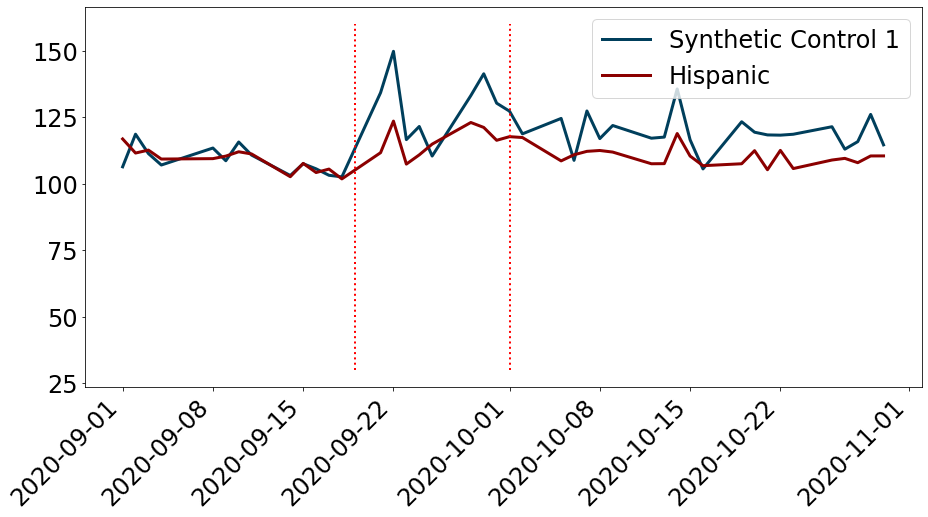

In [67]:
tempX=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempX=tempX[tempX.GEOID.isin(control1)]

tempX=tempX.iloc[:,1:].div(tempX.EstimateTotal, axis=0)
tempX.index=tempX.GEOID
tempX=tempX.drop('GEOID',axis=1).T


tempY=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempY=tempY[tempY.GEOID.isin(df_focusD.GEOID)]
tempY.index=tempY.GEOID
tempY
tempY=tempY.iloc[:,1:].div(tempY.EstimateTotal, axis=0)
tempY=tempY.drop('GEOID',axis=1).T.mean(axis=1)

from sklearn.linear_model import LinearRegression

reg=LinearRegression(positive=True, fit_intercept=False).fit(tempX,tempY)

inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(control1))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(df_focusD.GEOID)], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS/len(df_focusD.GEOID)
inv=inv*reg.coef_[:-1]
inv=inv.dropna(axis=1)
X=inv[:13] # control ridership
y= other[:13]# mean target ridership

# weights_lr=get_w(X, y)
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False, positive=True).fit(X, y).coef_
weights_lr.round(3)

plt.figure(figsize=(15,7))
plt.plot(inv.dot(weights_lr),label='Synthetic Control 1',color='#003F5C',linewidth=3)
plt.plot(other,label='Hispanic',lw=3, color='#8b0000')
plt.vlines(x=pd.to_datetime('2020/09/19'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.vlines(x=pd.to_datetime('2020/10/1'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper right')
plt.show()

<h4>Control 2 with race group hispanic</h4>

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


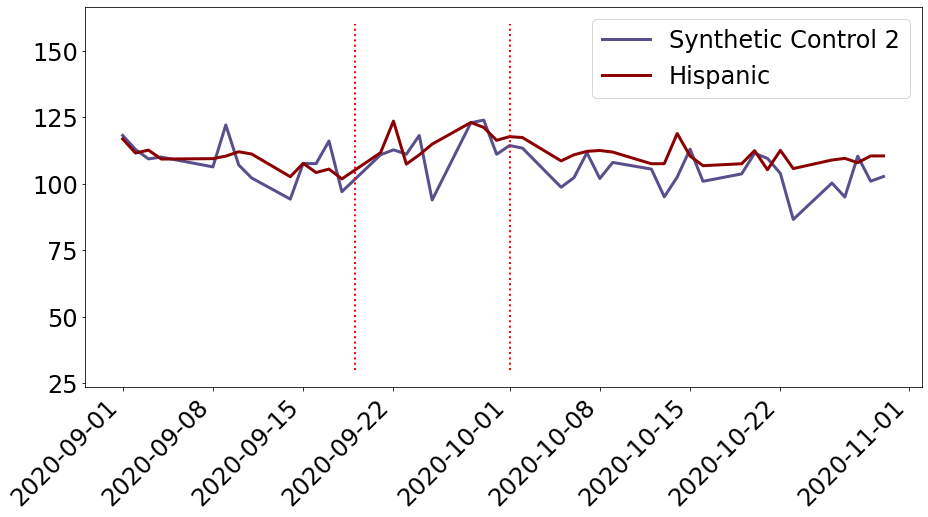

In [68]:
tempX=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempX=tempX[tempX.GEOID.isin(control2)]

tempX=tempX.iloc[:,1:].div(tempX.EstimateTotal, axis=0)
tempX.index=tempX.GEOID
tempX=tempX.drop('GEOID',axis=1).T


tempY=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempY=tempY[tempY.GEOID.isin(df_focusD.GEOID)]
tempY.index=tempY.GEOID
tempY
tempY=tempY.iloc[:,1:].div(tempY.EstimateTotal, axis=0)
tempY=tempY.drop('GEOID',axis=1).T.mean(axis=1)

from sklearn.linear_model import LinearRegression

reg=LinearRegression(positive=True, fit_intercept=False).fit(tempX,tempY)

inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(control2))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(df_focusD.GEOID)], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS/len(df_focusD.GEOID)
inv=inv*reg.coef_
inv=inv.dropna(axis=1)
X=inv[:13] # control ridership
y= other[:13]# mean target ridership

# weights_lr=get_w(X, y)
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False, positive=True).fit(X, y).coef_
weights_lr.round(3)

plt.figure(figsize=(15,7))
plt.plot(inv.dot(weights_lr),label='Synthetic Control 2',color='#58508D',linewidth=3)
plt.plot(other,label='Hispanic',lw=3, color='#8b0000')
plt.vlines(x=pd.to_datetime('2020/09/19'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.vlines(x=pd.to_datetime('2020/10/1'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper right')
plt.show()

<h4>Control 3 with race group hispanic</h4>

/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


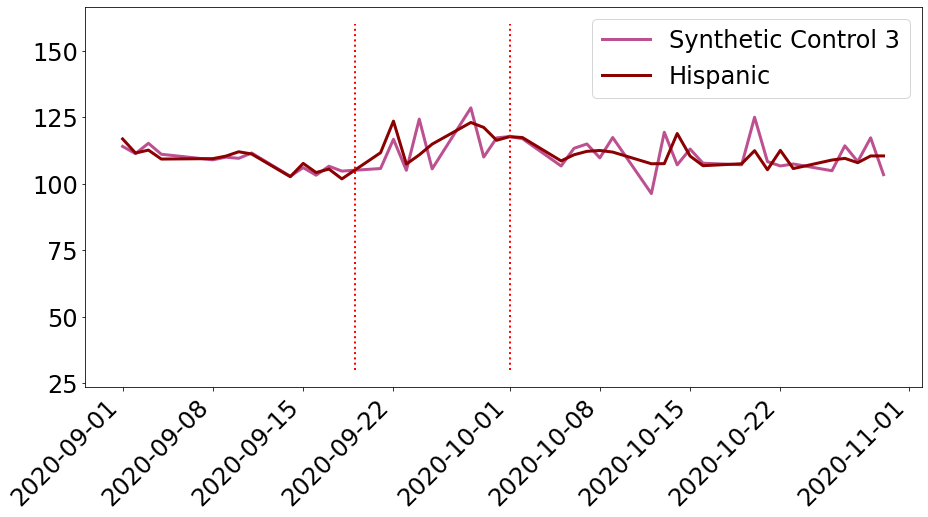

In [69]:
tempX=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempX=tempX[tempX.GEOID.isin(control3)]

tempX=tempX.iloc[:,1:].div(tempX.EstimateTotal, axis=0)
tempX.index=tempX.GEOID
tempX=tempX.drop('GEOID',axis=1).T


tempY=df_plt[['EstimateTotal','GEOID','Lessthan10000','10000to14999','15000to19999','20000to24999','25000to29999','30000to34999','35000to39999','40000to44999','45000to49999','50000to59999','60000to74999','75000to99999','100000to124999','125000to149999','150000to199999','200000ormore']]
tempY=tempY[tempY.GEOID.isin(df_focusD.GEOID)]
tempY.index=tempY.GEOID
tempY
tempY=tempY.iloc[:,1:].div(tempY.EstimateTotal, axis=0)
tempY=tempY.drop('GEOID',axis=1).T.mean(axis=1)

from sklearn.linear_model import LinearRegression

reg=LinearRegression(positive=True, fit_intercept=False).fit(tempX,tempY)

inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(control3))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(df_focusD.GEOID)], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS/len(df_focusD.GEOID)
# inv=inv*reg.coef_[:-1]
inv=inv.dropna(axis=1)
X=inv[:13] # control ridership
y= other[:13]# mean target ridership

# weights_lr=get_w(X, y)
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False, positive=True).fit(X, y).coef_
weights_lr.round(3)

plt.figure(figsize=(15,7))
plt.plot(inv.dot(weights_lr),label='Synthetic Control 3',color='#BC5090',lw=3)
plt.plot(other,label='Hispanic',lw=3,color='#8b0000')
plt.vlines(x=pd.to_datetime('2020/09/19'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.vlines(x=pd.to_datetime('2020/10/1'), ymin=30, ymax=160, linestyle=":",color='r', lw=2)
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper right')
plt.show()

In [1018]:
inv=pd.pivot_table(df_stop_activity[(df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday")& df_stop_activity.GEOID.isin(list(df_focusB.GEOID))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'],columns=['GEOID'], aggfunc=np.sum).PSNGR_BOARDINGS
other=pd.pivot_table(df_stop_activity[ (df_stop_activity['Day']!="Saturday") & (df_stop_activity['Day']!="Sunday") & df_stop_activity.GEOID.isin(list(df_focusC.GEOID))], values=['PSNGR_BOARDINGS'], index=['OPERATION_DATE'], aggfunc=np.sum).PSNGR_BOARDINGS.values/len(list(df_focusC.GEOID))


#TO BE FIXED

367506
364933
390669
394905
         black        white        asian     hispanic
0  7506.222222  3242.500000  8330.222222  7339.222222
1  8036.363636  3281.090909  8624.454545  7721.272727
2  7421.774194  2992.612903  8060.677419  7277.000000


<AxesSubplot:>

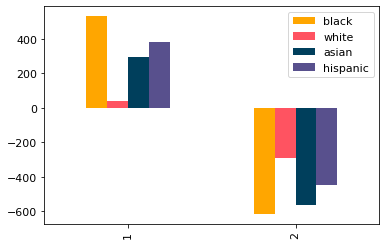

In [236]:
plt.rcParams.update({'font.size': 11})
f = pd.DataFrame(dict(
    black=statcalc(list(df_focusA['GEOID'])),
    white=statcalc(list(df_focusB['GEOID'])),
    asian=statcalc(list(df_focusC['GEOID'])),
    hispanic=statcalc(list(df_focusD['GEOID'])),
    #very_poor=statcalc(list(df_focusE['GEOID']))
    
    
))
print(f)

f.iloc[2]=(f.iloc[2]-f.iloc[1])
f.iloc[1]=(f.iloc[1]-f.iloc[0])
f.iloc[0]=np.NaN
f=f.dropna()

f.plot.bar(stacked=False,color=['#FFA600',  '#FF5361', '#003F5C', '#58508D','#BC5090'])

367506
364933
390669
394905
         black        white        asian     hispanic
0  7506.222222  3242.500000  8330.222222  7339.222222
1  8036.363636  3281.090909  8624.454545  7721.272727
2  7421.774194  2992.612903  8060.677419  7277.000000


<AxesSubplot:>

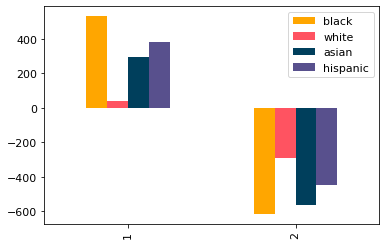

In [89]:
plt.rcParams.update({'font.size': 11})
f = pd.DataFrame(dict(
    black=statcalc(list(df_focusA['GEOID'])),
    white=statcalc(list(df_focusB['GEOID'])),
    asian=statcalc(list(df_focusC['GEOID'])),
    hispanic=statcalc(list(df_focusD['GEOID'])),
    #very_poor=statcalc(list(df_focusE['GEOID']))
    
    
))
print(f)

f.iloc[2]=(f.iloc[2]-f.iloc[1])
f.iloc[1]=(f.iloc[1]-f.iloc[0])
f.iloc[0]=np.NaN
f=f.dropna()

f.plot.bar(stacked=False,color=['#FFA600',  '#FF5361', '#003F5C', '#58508D','#BC5090'])

In [103]:
f

,black,white,asian,hispanic
1,530.141414,38.590909,294.232323,382.050505
2,-614.589443,-288.478006,-563.777126,-444.272727


In [99]:
a=f.iloc[1].values/[7421.774194,  2992.612903,  8060.677419,  7277.000000
]

In [104]:
a

array([-0.08280897, -0.0963967 , -0.06994166, -0.06105163])

409114
426692
399642


<AxesSubplot:>

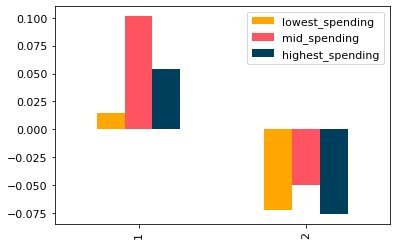

In [238]:
plt.rcParams.update({'font.size': 11})
f = pd.DataFrame(dict(
    lowest_spending=statcalc(list(df_tracts['percapitapublicfunds'].dropna().sort_values().index[:70])),
    mid_spending=statcalc(list(df_tracts['percapitapublicfunds'].dropna().sort_values().index[75:150])),
    highest_spending=statcalc(list(df_tracts['percapitapublicfunds'].dropna().sort_values().index[150:223])),
    
))

f.iloc[2]=(f.iloc[2]-f.iloc[1])/f.iloc[1]
f.iloc[1]=(f.iloc[1]-f.iloc[0])/f.iloc[0]
f.iloc[0]=np.NaN
f=f.dropna()

f.plot.bar(stacked=False,color=['#FFA600',  '#FF5361', '#003F5C', '#58508D','#BC5090'])

350878
388919
371072
376202


<AxesSubplot:>

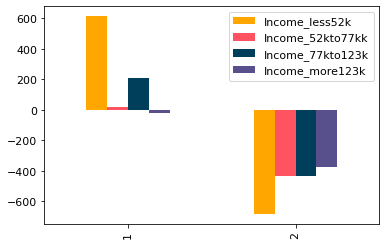

In [87]:
plt.rcParams.update({'font.size': 11})
f = pd.DataFrame(dict(
    Income_less52k=statcalc(one),
    Income_52kto77kk=statcalc(two),
    Income_77kto123k=statcalc(three),
    Income_more123k=statcalc(four)
))
f.iloc[2]=(f.iloc[2]-f.iloc[1])
f.iloc[1]=(f.iloc[1]-f.iloc[0])
f.iloc[0]=np.NaN
f=f.dropna()
f.plot.bar(stacked=False,color=[ '#FFA600', '#FF5361','#003F5C', '#58508D',])

In [88]:
f

,Income_less52k,Income_52kto77kk,Income_77kto123k,Income_more123k
1,612.464646,19.121212,206.580808,-22.176768
2,-682.360704,-433.841642,-432.636364,-374.964809


In [241]:
df_SAP

,Age,RaceDesc,LanguageSpoken,Expiration,DateIssued,CardIssuingAgency,FIPS,Initial Load,Study Card,card_id
53,52,Hispanic or Latino,English,10/31/2023,2020-12-09,King County Public Health,5.303302e+09,Subsidized Annual Pass,NaN,2824-1
55,53,Hispanic or Latino,English,10/31/2023,2021-11-17,King County Public Health,5.303302e+09,Subsidized Annual Pass,NaN,2824-3
75,67,White,English,8/31/2024,2021-04-20,DSHS - subsidized annual pass (remote enrollment),5.303301e+09,Subsidized Annual Pass,NaN,2878-1
80,69,White,English,7/31/2023,2020-11-16,DSHS - subsidized annual pass (remote enrollment),5.303303e+09,Subsidized Annual Pass,NaN,2898-1
81,70,White,English,7/31/2023,2021-12-22,DSHS - subsidized annual pass (remote enrollment),5.303303e+09,Subsidized Annual Pass,NaN,2898-2
...,...,...,...,...,...,...,...,...,...,...
117605,22,Not Specified,English,1/31/2023,2022-03-16,King County Public Health,5.303302e+09,Subsidized Annual Pass,NaN,272576-1
117608,29,Not Specified,English,1/31/2023,2022-03-16,King County Public Health,5.303303e+09,Subsidized Annual Pass,NaN,272582-1
117610,38,Other,English,1/31/2023,2022-03-16,King County Public Health,5.303303e+09,Subsidized Annual Pass,NaN,272586-1
117612,23,Not Specified,English,1/31/2023,2022-03-16,King County Public Health,5.303303e+09,Subsidized Annual Pass,NaN,272590-1


In [51]:
df_plt.GEOID[0]

53033032011

In [ ]:
# temp change to plot only focus areas on the map

df_plt=df_focus10
df_focus10

In [ ]:
map = folium.Map(location = [47.59505476958665, -122.15110269484644], tiles = "openstreetmap", zoom_start = 10)
fg0 = folium.FeatureGroup(name='Population by Census Tract',overlay=False).add_to(map)
# fg1 = folium.FeatureGroup(name='Percentage Black Population by Census Tract',overlay=False).add_to(map)
fg2 = folium.FeatureGroup(name='Percentage White Population by Census Tract',overlay=False).add_to(map)
# fg3 = folium.FeatureGroup(name='People below 200 pct income',overlay=False).add_to(map)
# fg4 = folium.FeatureGroup(name='Percent People below 200 pct income',overlay=False).add_to(map)
# fg5 = folium.FeatureGroup(name='Median Total Age',overlay=False).add_to(map)
##fg6 = folium.FeatureGroup(name='Gini',overlay=False).add_to(map)

Map0=folium.Choropleth(
            geo_data=df_plt.to_json(),
            data=df_plt,
    name='Percentage Black Population by Census Tract',
            columns=['GEOID', 'num_people'],
            key_on="feature.properties.GEOID",
    fill_color="Set2",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Percentage Black Population by Census Tract ',
            highlight=True
            ).geojson.add_to(fg0)



folium.features.GeoJson(
                    data=df_plt,
                    name='Percentage Black Population by Census Tract',
                    smooth_factor=2,
                    style_function=lambda x: {'fillColor':x['properties']['group']},
                    tooltip=folium.features.GeoJsonTooltip(
                        fields=['num_people',
                                'pct_black',
                                'pct_white',
                                'num_people_income_below_twohundredpct',
                                'pct_people_income_below_twohundredpct',
                                'gini',
                                'median_age_total',
                                'NAMELSAD',
                               ],
                        aliases=["Number of People:",
                                 "Percent Black:",
                                 "Percent White:",
                                 "Num Income less than 200%:",
                                 "Percent Income less than 200%:",
                                 "Gini:",
                                 'Median Age',
                                 "Name of Census Tract"
                                ], 
                        localize=True,
                        sticky=False,
                        labels=True,
                        style="""
                            background-color: #F0EFEF;
                            border: 2px solid black;
                            border-radius: 3px;
                            box-shadow: 3px;
                        """,
                        max_width=800,),
                            highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
                        ).add_to(Map0) 


# Map1=folium.Choropleth(
#             geo_data=df_plt.to_json(),
#             data=df_plt,
#     name='Percentage Black Population by Census Tract',
#             columns=['GEOID', 'group'],
#             key_on="feature.properties.GEOID",
#     fill_color="Set2",
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name='Number of Black Population by Census Tract ',
#             highlight=True
#             ).geojson.add_to(fg1)




# folium.features.GeoJson(
#                     data=df_plt,
#                     name='Percentage Black Population by Census Tract',
#                     smooth_factor=2,
#                     tooltip=folium.features.GeoJsonTooltip(
#                         fields=['num_people',
#                                 'pct_black',
#                                 'pct_white',
#                                 'num_people_income_below_twohundredpct',
#                                 'pct_people_income_below_twohundredpct',
#                                 'gini',
#                                 'median_age_total',
#                                 'NAMELSAD',
#                                ],
#                         aliases=["Number of People:",
#                                  "Percent Black:",
#                                  "Percent White:",
#                                  "Num Income less than 200%:",
#                                  "Percent Income less than 200%:",
#                                  "Gini:",
#                                  'Median Age',
#                                  "Name of Census Tract"
#                                 ], 
#                         localize=True,
#                         sticky=False,
#                         labels=True,
#                         style="""
#                             background-color: #F0EFEF;
#                             border: 2px solid black;
#                             border-radius: 3px;
#                             box-shadow: 3px;
#                         """,
#                         max_width=800,),
#                             highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
#                         ).add_to(Map1) 


Map2=folium.Choropleth(
            geo_data=df_plt.to_json(),
            data=df_plt,
    name='Percentage White Population by Census Tract',
            columns=['GEOID', 'group'],
            key_on="feature.properties.GEOID",
    fill_color="Set1",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Black Population by Census Tract ',
            highlight=True
            ).geojson.add_to(fg2)




folium.features.GeoJson(
                    data=df_plt,
                    name='Percentage White Population by Census Tract',
                    smooth_factor=2,
                    style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5},
                    tooltip=folium.features.GeoJsonTooltip(
                        fields=['num_people',
                                'pct_black',
                                'pct_white',
                                'num_people_income_below_twohundredpct',
                                'pct_people_income_below_twohundredpct',
                                'gini',
                                'median_age_total',
                                'NAMELSAD',
                               ],
                        aliases=["Number of People:",
                                 "Percent Black:",
                                 "Percent White:",
                                 "Num Income less than200%:",
                                 "Percent Income less than 200%:",
                                 "Gini:",
                                 'Median Age',
                                 "Name of Census Tract"
                                ], 
                        localize=True,
                        sticky=False,
                        labels=True,
                        style="""
                            background-color: #F0EFEF;
                            border: 2px solid black;
                            border-radius: 3px;
                            box-shadow: 3px;
                        """,
                        max_width=800,),
                            highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
                        ).add_to(Map2) 


# Map3=folium.Choropleth(
#             geo_data=df_plt.to_json(),
#             data=df_plt,
#     name='People below 200 pct income',
#             columns=['GEOID', 'num_people_income_below_twohundredpct'],
#             key_on="feature.properties.GEOID",
#     fill_color="YlGn",
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name='Number of people below 200 % federal income ',
#             highlight=True
#             ).geojson.add_to(fg3)




# folium.features.GeoJson(
#                     data=df_plt,
#                     name='People below 200 pct income',
#                     smooth_factor=2,
#                     style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5},
#                     tooltip=folium.features.GeoJsonTooltip(
#                          fields=['num_people',
#                                 'pct_black',
#                                 'pct_white',
#                                 'num_people_income_below_twohundredpct',
#                                 'pct_people_income_below_twohundredpct',
#                                 'gini',
#                                 'median_age_total',
#                                 'NAMELSAD',
#                                ],
#                         aliases=["Number of People:",
#                                  "Percent Black:",
#                                  "Percent White:",
#                                  "Num Income less than 200%:",
#                                  "Percent Income less than 200%:",
#                                  "Gini:",
#                                  'Median Age',
#                                  "Name of Census Tract"
#                                 ], 
#                         localize=True,
#                         sticky=False,
#                         labels=True,
#                         style="""
#                             background-color: #F0EFEF;
#                             border: 2px solid black;
#                             border-radius: 3px;
#                             box-shadow: 3px;
#                         """,
#                         max_width=800,),
#                             highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
#                         ).add_to(Map3) 


# Map4=folium.Choropleth(
#             geo_data=df_plt.to_json(),
#             data=df_plt,
#     name='Percent People below 200 pct income',
#             columns=['GEOID', 'pct_people_income_below_twohundredpct'],
#             key_on="feature.properties.GEOID",
#     fill_color="YlGn",
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name='Percent People below 200 pct incomee ',
#             highlight=True
#             ).geojson.add_to(fg4)




# folium.features.GeoJson(
#                     data=df_plt,
#                     name='Percent People below 200 pct income',
#                     smooth_factor=2,
#                     style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5},
#                     tooltip=folium.features.GeoJsonTooltip(
#                         fields=['num_people',
#                                 'pct_black',
#                                 'pct_white',
#                                 'num_people_income_below_twohundredpct',
#                                 'pct_people_income_below_twohundredpct',
#                                 'gini',
#                                 'median_age_total',
#                                 'NAMELSAD',
#                                ],
#                         aliases=["Number of People:",
#                                  "Percent Black:",
#                                  "Percent White:",
#                                  "Num Income>200%:",
#                                  "Percent Income>200%:",
#                                  "Gini:",
#                                  'Median Age',
#                                  "Name of Census Tract"
#                                 ], 
#                         localize=True,
#                         sticky=False,
#                         labels=True,
#                         style="""
#                             background-color: #F0EFEF;
#                             border: 2px solid black;
#                             border-radius: 3px;
#                             box-shadow: 3px;
#                         """,
#                         max_width=800,),
#                             highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
#                         ).add_to(Map4) 


# Map5=folium.Choropleth(
#             geo_data=df_plt.to_json(),
#             data=df_plt,
#     name='Median Age',
#             columns=['GEOID', 'median_age_total'],
#             key_on="feature.properties.GEOID",
#     fill_color="YlGn",
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name='Median Age ',
#             highlight=True
#             ).geojson.add_to(fg5)




# folium.features.GeoJson(
#                     data=df_plt,
#                     name='Median Age',
#                     smooth_factor=2,
#                     style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5},
#                     tooltip=folium.features.GeoJsonTooltip(
#                         fields=['num_people',
#                                 'pct_black',
#                                 'pct_white',
#                                 'num_people_income_below_twohundredpct',
#                                 'pct_people_income_below_twohundredpct',
#                                 'gini',
#                                 'median_age_total',
#                                 'NAMELSAD',
#                                ],
#                         aliases=["Number of People:",
#                                  "Percent Black:",
#                                  "Percent White:",
#                                  "Num Income less than 200%:",
#                                  "Percent Income less than 200%:",
#                                  "Gini:",
#                                  'Median Age',
#                                  "Name of Census Tract"
#                                 ], 
#                         localize=True,
#                         sticky=False,
#                         labels=True,
#                         style="""
#                             background-color: #F0EFEF;
#                             border: 2px solid black;
#                             border-radius: 3px;
#                             box-shadow: 3px;
#                         """,
#                         max_width=800,),
#                             highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
#                         ).add_to(Map5) 


# Map6=folium.Choropleth(
#             geo_data=df_plt.to_json(),
#             data=df_plt,
#     name='Gini',
#             columns=['GEOID', 'gini'],
#             key_on="feature.properties.GEOID",
#     fill_color="YlGn",
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name='Gini by Census Tract ',
#             highlight=True
#             ).geojson.add_to(fg6) 




# folium.features.GeoJson(
#                     data=df_plt,
#                     name='Gini',
#                     smooth_factor=2,
#                     style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5},
#                     tooltip=folium.features.GeoJsonTooltip(
#                        fields=['num_people',
#                                 'pct_black',
#                                 'pct_white',
#                                 'num_people_income_below_twohundredpct',
#                                 'pct_people_income_below_twohundredpct',
#                                 'gini',
#                                 'median_age_total',
#                                 'NAMELSAD',
#                                ],
#                         aliases=["Number of People:",
#                                  "Percent Black:",
#                                  "Percent White:",
#                                  "Num Income less than 200%:",
#                                  "Percent Income less than 200%:",
#                                  "Gini:",
#                                  'Median Age',
#                                  "Name of Census Tract"
#                                 ], 
#                         localize=True,
#                         sticky=False,
#                         labels=True,
#                         style="""
#                             background-color: #F0EFEF;
#                             border: 2px solid black;
#                             border-radius: 3px;
#                             box-shadow: 3px;
#                         """,
#                         max_width=800,),
#                             highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
#                         ).add_to(Map6) 

folium.TileLayer('openstreetmap',overlay=True,name="Street View").add_to(map)
folium.TileLayer('Stamen Terrain',overlay=True,name="Terrain View").add_to(map)
folium.LayerControl(collapsed=False).add_to(map)

map



EDA on First Dataset

In [ ]:
df_q1.head()

In [ ]:
df_q1['ACTUAL_START_TIME']=df_q1['ACTUAL_START_TIME']+', '+df_q1['OPERATION_DATE']
df_q1['SCHED_START_TIME']=df_q1['SCHED_START_TIME']+', '+df_q1['OPERATION_DATE']
df_q1['ACTUAL_END_TIME']=df_q1['ACTUAL_END_TIME']+', '+df_q1['OPERATION_DATE']
df_q1['SCHED_END_TIME']=df_q1['SCHED_END_TIME']+', '+df_q1['OPERATION_DATE']

Converting all times to datetime

In [ ]:
df_q1['SCHED_START_TIME']=pd.to_datetime(df_q1['SCHED_START_TIME'])
df_q1['SCHED_END_TIME']=pd.to_datetime(df_q1['SCHED_END_TIME'])
df_q1['ACTUAL_START_TIME']=pd.to_datetime(df_q1['ACTUAL_START_TIME'])
df_q1['ACTUAL_END_TIME']=pd.to_datetime(df_q1['ACTUAL_END_TIME'])

First let us look at date and time trends

In [ ]:
df_q1['SCHED_START_TIME'].dt.day.value_counts().sort_index().plot(kind='bar')


In [ ]:
df_q1['SCHED_START_TIME'].dt.weekday.value_counts().sort_index().plot(kind='bar')

In [ ]:

df_q1['SCHED_START_TIME'].dt.hour.value_counts().sort_index().plot(kind='bar')


The service type determines if it is local or express with LL being a local transit and EE being express.

In [ ]:
df_q1['SERVICE_TYPE_CD'].value_counts().plot(kind='bar')

Inbound or outbound; inbound is towards primary attraction, which is usually the direction the route operates toward during the AM peak.

In [ ]:
df_q1['INBD_OUTBD_CD'].value_counts().plot(kind='bar')

In [ ]:
df_q1_in=df_q1[df_q1['INBD_OUTBD_CD']=='I']
df_q1_out=df_q1[df_q1['INBD_OUTBD_CD']=='O']

In [ ]:
df_q1_out['FIRST_STOP_NM'].value_counts()[:5].plot(kind='barh')

In [ ]:
df_q1_out['LAST_STOP_NM'].value_counts()[:5].plot(kind='barh')

In [ ]:
df_q1_in['FIRST_STOP_NM'].value_counts()[:5].plot(kind='barh')

In [ ]:
df_q1_in['LAST_STOP_NM'].value_counts()[:5].plot(kind='barh')

Most common last stops for inbound are not same as the most common first stops for outbound. 

Breaking up times to 5 different periods

In [ ]:
df_q1_midnight=df_q1[df_q1['SCHED_START_TIME'].dt.hour<5]
df_q1_morning=df_q1[(df_q1['SCHED_START_TIME'].dt.hour<12)& (df_q1['SCHED_START_TIME'].dt.hour>5)]
df_q1_noon=df_q1[(df_q1['SCHED_START_TIME'].dt.hour<17)& (df_q1['SCHED_START_TIME'].dt.hour>12)]
df_q1_evening=df_q1[(df_q1['SCHED_START_TIME'].dt.hour<22)& (df_q1['SCHED_START_TIME'].dt.hour>17)]
df_q1_night=df_q1[df_q1['SCHED_START_TIME'].dt.hour>22]

In [ ]:
df_q1_midnight['FIRST_STOP_NM'].value_counts()[:5].plot(kind='barh')

In [ ]:
df_q1_morning['FIRST_STOP_NM'].value_counts()[:5].plot(kind='barh')

In [ ]:
df_q1_noon['FIRST_STOP_NM'].value_counts()[:5].plot(kind='barh')

In [ ]:
df_q1_evening['FIRST_STOP_NM'].value_counts()[:5].plot(kind='barh')

In [ ]:
df_q1_night['FIRST_STOP_NM'].value_counts()[:5].plot(kind='barh')

In [ ]:
df_q1['FIRST_STOP_NM'].value_counts()[:20].plot(kind='barh')